# Patient Access to and Use of Electronic Medical Records -- Data Analysis
In this notebook, we'll take the cleaned and condensed datasets and run a machine learning analysis to predict access to and use of electronic medical records (EMRs).

## Table of Contents
<ul>
  <li><a href="#MLanalysis">Machine Learning Analysis</a></li>
  <ul>
      <li><a href="#finmanip">Final Data Manipulations</a></li>
      <li><a href="#modeloae">Model for `offeredaccesseither` Outcome</a></li>
      <ul>
          <li><a href="#prelimmodeloae">Preliminary Model</a></li>
          <li><a href="#tunemodeloae">Model Tuning</a></li>
          <li><a href="#binmodeloae">Binarizing the Outcome</a></li>
          <li><a href="#tunebinmodeloae">Tuning the Binary Model</a></li>
          <li><a href="#manfeatreductoae">Manual Feature Reduction</a></li>
          <li><a href="#sumfinvarsoae">Summary of Final Variables</a></li>
      </ul>
      <li><a href="#modelaor">Model for `accessonlinerecord` Outcome</a></li>
      <ul>
          <li><a href="#prelimmodelaor">Preliminary Model</a></li>
          <li><a href="#tunemodelaor">Model Tuning</a></li>
          <li><a href="#binmodelaor">Binarizing the Outcome</a></li>
          <li><a href="#tunebinmodelaor">Tuning the Binary Model</a></li>
          <li><a href="#manfeatreductaor">Manual Feature Reduction</a></li>
          <li><a href="#sumfinvarsaor">Summary of Final Variables</a></li>
      </ul> 
  </ul>      
<li><a href="#overallsum">Overall Summary</a></li> 
<li><a href="#conclusions">Conclusions</a></li> 
  <ul>
      <li><a href="#limitations">Limitations</a></li>
      <li><a href="#improve">Areas for Improvement and Future Study</a></li>
</ul>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import statsmodels.api as sm
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

<a id="MLanalysis"></a>
## Machine Learning Analysis
<a id="finmanip"></a>
### Final Data Manipulations

In [2]:
# read in the data; these variables were pre-screened in the exploratory notebook
df_train = pd.read_csv('data/HINTS_train.csv.gz', compression='gzip')
df_test = pd.read_csv('data/HINTS_test.csv.gz', compression='gzip')

In [3]:
# check that data loaded
display(df_train.head())
display(df_test.head())

,Unnamed: 0,stratum,highspanli,nchsurcode2013,censdiv,useinternet,internet_broadbnd,electronic_selfhealthinfo,havedevice_cat,tablethealthwellnessapps,...,hhinc,smokestat,survey_cycle,offeredaccesseither,phq4_cat,bmi_cat,wkminmodex_cat,avgdrinks_cat,whruseinet_pubvother,healthins_pubpriv
0,653,LM,2,1,3,1,2,1,2,1,...,5,3,2,1,1,1,1,1,2,1
1,10528,HM,2,3,1,1,1,1,5,2,...,3,1,5,1,1,2,1,1,2,2
2,2269,HM,2,1,2,1,1,1,5,1,...,5,1,2,1,2,4,1,4,2,1
3,9279,LM,2,1,8,1,2,1,5,1,...,5,3,5,1,1,2,3,2,2,3
4,7695,HM,2,2,5,2,-1,1,5,3,...,1,2,3,1,1,3,2,2,-1,3


,Unnamed: 0,stratum,highspanli,nchsurcode2013,censdiv,useinternet,internet_broadbnd,electronic_selfhealthinfo,havedevice_cat,tablethealthwellnessapps,...,hhinc,smokestat,survey_cycle,offeredaccesseither,phq4_cat,bmi_cat,wkminmodex_cat,avgdrinks_cat,whruseinet_pubvother,healthins_pubpriv
0,3959,HM,2,3,9,1,2,1,5,2,...,3,2,3,2,1,4,4,4,2,2
1,8595,LM,2,5,1,1,2,1,2,2,...,5,3,4,1,1,1,2,3,2,3
2,3742,HM,2,1,9,2,-1,2,2,3,...,4,1,3,3,1,2,1,2,-1,1
3,2820,HM,2,4,7,1,1,1,5,1,...,2,2,2,2,1,4,1,1,2,1
4,10671,HM,2,1,7,1,2,1,2,1,...,5,3,5,1,1,1,5,2,2,1


In [4]:
# remove the index columns
df_train.drop(columns = ['Unnamed: 0'], inplace = True)
df_test.drop(columns = ['Unnamed: 0'], inplace = True)

In [5]:
df_train.columns

Index(['stratum', 'highspanli', 'nchsurcode2013', 'censdiv', 'useinternet',
       'internet_broadbnd', 'electronic_selfhealthinfo', 'havedevice_cat',
       'tablethealthwellnessapps', 'tablet_achievegoal', 'tablet_makedecision',
       'tablet_discussionshcp', 'intrsn_visitedsocnet', 'intrsn_sharedsocnet',
       'intrsn_supportgroup', 'intrsn_youtube', 'regularprovider',
       'freqgoprovider', 'qualitycare', 'healthinsurance',
       'accessonlinerecord', 'generalhealth', 'ownabilitytakecarehealth',
       'medconditions_diabetes', 'medconditions_highbp',
       'medconditions_heartcondition', 'medconditions_depression',
       'everhadcancer', 'maritalstatus', 'selfgender', 'agegrpb', 'educa',
       'raceethn5', 'hhinc', 'smokestat', 'survey_cycle',
       'offeredaccesseither', 'phq4_cat', 'bmi_cat', 'wkminmodex_cat',
       'avgdrinks_cat', 'whruseinet_pubvother', 'healthins_pubpriv'],
      dtype='object')

We will use logistic regression as our model, since it gives interpretable coefficients that will allow us to identify groups who are more and less likely to be offered use of an EMR and who are more and less likely to use the EMR. Since the outcome variables have > 2 categories, we'll use a multinomial model.  
To set up the model we'll need to create dummy variables for any categorical variable with > 2 categories. It will also be helpful to recode the predictor and outcome variables as N=0, Y=1 (where applicable) to simplify model interpretation and to make "No" the reference category. The predictor variables currently are coded Y=1, N=2. To refresh our memory, let's look at the values for each column again.

In [6]:
for col in df_train.columns:
    print(col, '\n', df_train[col].value_counts())

stratum 
 HM    3185
LM    2305
Name: stratum, dtype: int64
highspanli 
 2    5031
1     459
Name: highspanli, dtype: int64
nchsurcode2013 
 1    1952
2    1291
3    1134
4     456
5     389
6     268
Name: nchsurcode2013, dtype: int64
censdiv 
 5    1309
9     883
7     770
3     708
2     579
8     446
4     297
6     281
1     217
Name: censdiv, dtype: int64
useinternet 
 1    4615
2     875
Name: useinternet, dtype: int64
internet_broadbnd 
  2    2320
 1    2295
-1     875
Name: internet_broadbnd, dtype: int64
electronic_selfhealthinfo 
 1    3999
2    1491
Name: electronic_selfhealthinfo, dtype: int64
havedevice_cat 
 5    2995
2    1527
3     497
1     258
4     213
Name: havedevice_cat, dtype: int64
tablethealthwellnessapps 
  1    2561
 2    2044
-1     710
 3     175
Name: tablethealthwellnessapps, dtype: int64
tablet_achievegoal 
  2    2614
 1    2166
-1     710
Name: tablet_achievegoal, dtype: int64
tablet_makedecision 
  2    2856
 1    1924
-1     710
Name: tablet_makede

The following are of type Y/N. They'll be recoded from Y=1, N=2, to Y=1, N=0.

In [7]:
# make list of Y/N vars to recode
vars_yn = ['highspanli', 'useinternet', 'electronic_selfhealthinfo', 'intrsn_visitedsocnet', 'intrsn_sharedsocnet',\
          'intrsn_supportgroup', 'intrsn_youtube', 'regularprovider', 'healthinsurance', 'medconditions_diabetes', \
          'medconditions_highbp', 'medconditions_heartcondition', 'medconditions_depression', 'everhadcancer']

In [8]:
# make df to hold recoded vars
df_train_recode = df_train.copy()
df_test_recode = df_test.copy()

In [9]:
# recode the Y/N vars; all  we have to do is change "N" from 2 to 0
for var in vars_yn:
    df_train_recode.loc[df_train[var] == 2, var] = 0

In [10]:
# check that it worked
for col in df_train_recode.columns:
    print(col, '\n', df_train_recode[col].value_counts())

stratum 
 HM    3185
LM    2305
Name: stratum, dtype: int64
highspanli 
 0    5031
1     459
Name: highspanli, dtype: int64
nchsurcode2013 
 1    1952
2    1291
3    1134
4     456
5     389
6     268
Name: nchsurcode2013, dtype: int64
censdiv 
 5    1309
9     883
7     770
3     708
2     579
8     446
4     297
6     281
1     217
Name: censdiv, dtype: int64
useinternet 
 1    4615
0     875
Name: useinternet, dtype: int64
internet_broadbnd 
  2    2320
 1    2295
-1     875
Name: internet_broadbnd, dtype: int64
electronic_selfhealthinfo 
 1    3999
0    1491
Name: electronic_selfhealthinfo, dtype: int64
havedevice_cat 
 5    2995
2    1527
3     497
1     258
4     213
Name: havedevice_cat, dtype: int64
tablethealthwellnessapps 
  1    2561
 2    2044
-1     710
 3     175
Name: tablethealthwellnessapps, dtype: int64
tablet_achievegoal 
  2    2614
 1    2166
-1     710
Name: tablet_achievegoal, dtype: int64
tablet_makedecision 
  2    2856
 1    1924
-1     710
Name: tablet_makede

In [11]:
# repeat for test set
for var in vars_yn:
    df_test_recode.loc[df_test[var] == 2, var] = 0

All of the rest of the variables except `stratum` (which is coded as a categorical) have >= 3 categories, so we'll need to make dummy variables for them.

In [12]:
# list of variables that don't need to be dummied
vars_nodum = vars_yn
vars_nodum.append('stratum')
vars_nodum.append('accessonlinerecord')
vars_nodum.append('offeredaccesseither')

In [13]:
# list of variables that need dummies made
vars_dum = list(set(df_train.columns) - set(vars_nodum))

In [14]:
vars_dum

['wkminmodex_cat',
 'healthins_pubpriv',
 'selfgender',
 'whruseinet_pubvother',
 'internet_broadbnd',
 'survey_cycle',
 'ownabilitytakecarehealth',
 'tablet_achievegoal',
 'educa',
 'tablethealthwellnessapps',
 'hhinc',
 'bmi_cat',
 'nchsurcode2013',
 'phq4_cat',
 'maritalstatus',
 'censdiv',
 'smokestat',
 'freqgoprovider',
 'generalhealth',
 'tablet_discussionshcp',
 'agegrpb',
 'qualitycare',
 'raceethn5',
 'avgdrinks_cat',
 'tablet_makedecision',
 'havedevice_cat']

We'll generate dummy variables, dropping the first category (it will be the reference group) of each.

In [15]:
# create dummy variables -- training set
df_train_dums = pd.get_dummies(df_train_recode, prefix = vars_dum, columns = vars_dum, drop_first = True)

In [16]:
# check to see if it worked
df_train_dums.head()

,stratum,highspanli,useinternet,electronic_selfhealthinfo,intrsn_visitedsocnet,intrsn_sharedsocnet,intrsn_supportgroup,intrsn_youtube,regularprovider,healthinsurance,...,avgdrinks_cat_2,avgdrinks_cat_3,avgdrinks_cat_4,avgdrinks_cat_5,tablet_makedecision_1,tablet_makedecision_2,havedevice_cat_2,havedevice_cat_3,havedevice_cat_4,havedevice_cat_5
0,LM,0,1,1,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
1,HM,0,1,1,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
2,HM,0,1,1,1,0,1,1,1,1,...,0,0,1,0,1,0,0,0,0,1
3,LM,0,1,1,1,0,0,1,1,1,...,1,0,0,0,0,1,0,0,0,1
4,HM,0,0,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1


In [17]:
df_train_dums.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 111 columns):
 #    Column                        Dtype 
---   ------                        ----- 
 0    stratum                       object
 1    highspanli                    int64 
 2    useinternet                   int64 
 3    electronic_selfhealthinfo     int64 
 4    intrsn_visitedsocnet          int64 
 5    intrsn_sharedsocnet           int64 
 6    intrsn_supportgroup           int64 
 7    intrsn_youtube                int64 
 8    regularprovider               int64 
 9    healthinsurance               int64 
 10   accessonlinerecord            int64 
 11   medconditions_diabetes        int64 
 12   medconditions_highbp          int64 
 13   medconditions_heartcondition  int64 
 14   medconditions_depression      int64 
 15   everhadcancer                 int64 
 16   offeredaccesseither           int64 
 17   wkminmodex_cat_2              uint8 
 18   wkminmodex_cat_3          

In [18]:
# OK, it worked. Repeat for test set
df_test_dums = pd.get_dummies(df_test_recode, prefix = vars_dum, columns = vars_dum, drop_first = True)

`stratum` is supposed to be categorical but it seems to have been convert to an object again. For consistency, and to avoid having to worry about what type it is, let's just code it as 0 (LM) or 1 (HM).


In [19]:
# make an integer code for stratum, since doesn't seem to stay as categorical
df_train_dums['stratum_cd'] = 0
df_train_dums.loc[df_train_recode['stratum'] == 'HM', 'stratum_cd'] = 1

In [20]:
# check it
display(df_train_dums['stratum'].value_counts())
display(df_train_dums['stratum_cd'].value_counts())

HM    3185
LM    2305
Name: stratum, dtype: int64

1    3185
0    2305
Name: stratum_cd, dtype: int64

In [21]:
# OK, can drop stratum
df_train_dums.drop(columns = ['stratum'], inplace = True)

In [22]:
# repeat for test set
df_test_dums['stratum_cd'] = 0
df_test_dums.loc[df_test_recode['stratum'] == 'HM', 'stratum_cd'] = 1

In [23]:
df_test_dums.drop(columns = ['stratum'], inplace = True)

In [24]:
# how many predictor variables? (-2 for the outcome variables)
df_train_dums.shape[1] - 2

109

Expanding the categoricals has more than doubled the number of predictors. We will want to winnow this down.

Let's also look at the coding of the outcome variables.

In [25]:
df_train['offeredaccesseither'].value_counts()

1    3418
2    1512
3     560
Name: offeredaccesseither, dtype: int64

`offeredaccesseither` has the same Y=1/N=2 coding with "don't know" as 3. We previously decided to keep "don't know" as a separate category. This ordering makes sense, so we'll leave it alone.

In [26]:
df_train['accessonlinerecord'].value_counts()

0    3196
1     965
2     763
3     296
4     270
Name: accessonlinerecord, dtype: int64

This variable is ordered by increasing frequency of use with none/never = 0. We left it as multicategorical to see if we can predict who uses the EMR less and more. This coding will be fine.

<a id="modeloae"></a>
### Model for `offeredaccesseither` Outcome

This outcome variable denotes whether a respondent has been offered EMR access by either their healthcare provider (HCP) or their insurer. The categories, as above, are "yes", "no", and "don't know". Our preliminary decision was to maintain these three categories, since "don't know" may delineate a different group, perhaps less engaged. However, this category has few entries relative to the other two, and may be hard to accurately predict, so we may need to reassess this decision. 

Make the X and Y matrices for this outcome variable. In the univariate analysis, `medconditions_diabetes`, `medconditions_highBP`, and `medconditions_heartcondition` were non-significant predictors this outcome, so  they need to be removed from the X matrices. 

In [27]:
# make the X matrices for offeredaccesseither
X_train_ofracceith = df_train_dums.drop(columns = ['offeredaccesseither', 'accessonlinerecord', 'medconditions_diabetes',\
                                                  'medconditions_highbp','medconditions_heartcondition'])
X_test_ofracceith = df_test_dums.drop(columns = ['offeredaccesseither', 'accessonlinerecord', 'medconditions_diabetes',\
                                                  'medconditions_highbp','medconditions_heartcondition'])

In [28]:
# check the columns
X_train_ofracceith.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 106 columns):
 #    Column                      Dtype
---   ------                      -----
 0    highspanli                  int64
 1    useinternet                 int64
 2    electronic_selfhealthinfo   int64
 3    intrsn_visitedsocnet        int64
 4    intrsn_sharedsocnet         int64
 5    intrsn_supportgroup         int64
 6    intrsn_youtube              int64
 7    regularprovider             int64
 8    healthinsurance             int64
 9    medconditions_depression    int64
 10   everhadcancer               int64
 11   wkminmodex_cat_2            uint8
 12   wkminmodex_cat_3            uint8
 13   wkminmodex_cat_4            uint8
 14   wkminmodex_cat_5            uint8
 15   healthins_pubpriv_2         uint8
 16   healthins_pubpriv_3         uint8
 17   selfgender_2                uint8
 18   selfgender_3                uint8
 19   whruseinet_pubvother_1      uint8
 20   whruse

In [29]:
# make the Y matrices
Y_train_ofracceith = df_train_dums['offeredaccesseither']
Y_test_ofracceith = df_test_dums['offeredaccesseither']

<a id="prelimmodeloae"></a>
#### Preliminary Model

Since we have so many predictor variables (features), we are in danger of creating an overfit model. We'll use scikit-learn's Recursive Feature Elimination with Cross-Validation ([RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)) to search for an optimal set of variables.  
Since the "don't know" outcome is somewhat rare (~10% of outcomes in the training set), we'll use balanced class weights to deal with the imbalance.  
To minimize both false negatives & false positives, we'll use the F1 score as the scoring metric for RFECV.

In [32]:
# fit the model using recursive feature elimination and logistic regression
logreg1 = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', C = 1, n_jobs = -1)
model1 = RFECV(logreg1, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
model1.fit(X_train_ofracceith, Y_train_ofracceith)
Y_pred1 = model1.predict(X_train_ofracceith)
# comparing training and test scores to assess for possible overfitting
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_ofracceith, Y_pred1)
Y_pred2 = model1.predict(X_test_ofracceith)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_ofracceith, Y_pred2)

Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator wit

RFECV reduces the model from 106 to 64 features. However, precision and accuracy are relatively poor. There is not a big difference between the training and test set results that would obviously point to overfitting. 

<a id="tunemodeloae"></a>
#### Model Tuning
Next, we'll attempt to tune this model to see if the fit improves.
We can check the effect of using balanced class weights, explore different values for the logistic regression regularization parameter `C` and try different step sizes to remove more than one parameter at each iteration.

In [33]:
# tune the multinomial LR model
parameters = [
    {                                
                'estimator__class_weight': ['balanced', None],
                'estimator__C':  [0.01, 0.1, 1, 10, 100], 
                'step': [1, 3, 5],
    }]
logreg2 = LogisticRegression(multi_class = 'multinomial', n_jobs = -1)
rfecv = RFECV(logreg2, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
clf = GridSearchCV(rfecv, parameters, n_jobs = -1, verbose = 2)
clf.fit(X_train_ofracceith, Y_train_ofracceith)
Y_pred3 = clf.predict(X_train_ofracceith)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_ofracceith, Y_pred3)
Y_pred4 = clf.predict(X_test_ofracceith)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_ofracceith, Y_pred4)
print("\nBest Parameters:", clf.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
training set scores: 
confusion matrix:
 [[2364  522  532]
 [ 408  645  459]
 [ 137  127  296

The tuned model selected more features (81 vs 64) using a lower `C` value (0.01 vs 1). Again, results for the training and test sets are similar, indicating overfitting is likely not an issue. However, precision and recall barely changed and are still poor.  

<a id="binmodeloae"></a>
#### Binarizing the Outcome  
It is possible that in trying to increase correct classification of the rare "don't know" category, the model is doing worse at classifying the "yes" and "no" categories. A workaround for this would be to merge "don't know" with "no", since respondents who answered either way don't have access to the EMR, and both would similarly be candidates for better education/outreach. Let's take this approach.  
We'll recode "no" and "don't know" as 0, and leave "yes" as 1, keeping with logistic regression convention.

In [34]:
# try binary outcome; combine "no" and "don't know"
Y_train_ofracceith_bin = Y_train_ofracceith.copy()
Y_train_ofracceith_bin.loc[(Y_train_ofracceith == 2) | (Y_train_ofracceith == 3) ] = 0

In [35]:
# check this came out right
Y_train_ofracceith_bin.value_counts()

1    3418
0    2072
Name: offeredaccesseither, dtype: int64

In [36]:
# repeat for test set
Y_test_ofracceith_bin = Y_test_ofracceith.copy()
Y_test_ofracceith_bin.loc[(Y_test_ofracceith == 2) | (Y_test_ofracceith == 3) ] = 0

In [37]:
# fit a LR model to the binary outcome variable
logreg3 = LogisticRegression(class_weight = 'balanced', C = 1, n_jobs = -1)
model2 = RFECV(logreg3, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
model2.fit(X_train_ofracceith, Y_train_ofracceith_bin)
Y_pred5 = model2.predict(X_train_ofracceith)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_ofracceith_bin, Y_pred5)
Y_pred6 = model2.predict(X_test_ofracceith)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_ofracceith_bin, Y_pred6)

Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator wit

<a id="tunebinmodeloae"></a>
#### Tuning the Binary Model
The preliminary binary model results in 52 features and ~10% improved precision and ~25% improved recall.  
Now we'll try tuning this model. We'll use the same parameter grid as before.

In [38]:
# tune the binary LR model. 
# use same parameter grid as above
logreg4 = LogisticRegression(n_jobs = -1)
rfecv2 = RFECV(logreg4, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
clf2 = GridSearchCV(rfecv2, parameters, n_jobs = -1, verbose = 2)
clf2.fit(X_train_ofracceith, Y_train_ofracceith_bin)
Y_pred7 = clf2.predict(X_train_ofracceith)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_ofracceith_bin, Y_pred7)
Y_pred8 = clf2.predict(X_test_ofracceith)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_ofracceith_bin, Y_pred8)
print("\nBest Parameters:", clf2.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
training set scores: 
confusion matrix:
 [[1428  644]
 [ 923 2495]]
precision: 0.72410; recall: 0.71457, accuracy: 0.71457
test set scores: 
confusion matrix:
 [[ 604  305]
 [ 394 1025]]
precision: 0.70607; recall: 0.69974, accuracy: 0.69974

Best Parameters: {'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'step': 1}


This model yields a very small improvement in precision and recall, but has 41 more features. Since the first model is more parsimonious, we'll keep it.

In [39]:
# make a dataframe containing only the columns identified by the initial binary model (52 features)
X_train_ofracceith_rfe = X_train_ofracceith.loc[:, model2.support_]

In [40]:
# see which columns are left
X_train_ofracceith_rfe.columns

Index(['highspanli', 'useinternet', 'electronic_selfhealthinfo',
       'regularprovider', 'healthinsurance', 'everhadcancer',
       'healthins_pubpriv_2', 'selfgender_2', 'whruseinet_pubvother_1',
       'whruseinet_pubvother_2', 'survey_cycle_3', 'survey_cycle_4',
       'survey_cycle_5', 'ownabilitytakecarehealth_5', 'tablet_achievegoal_1',
       'tablet_achievegoal_2', 'educa_3', 'educa_4',
       'tablethealthwellnessapps_1', 'hhinc_1', 'hhinc_2', 'nchsurcode2013_6',
       'phq4_cat_3', 'maritalstatus_2', 'maritalstatus_3', 'maritalstatus_4',
       'maritalstatus_5', 'maritalstatus_6', 'censdiv_2', 'censdiv_6',
       'censdiv_7', 'censdiv_8', 'smokestat_2', 'smokestat_3',
       'freqgoprovider_2', 'freqgoprovider_3', 'freqgoprovider_4',
       'freqgoprovider_5', 'freqgoprovider_6', 'generalhealth_2',
       'generalhealth_3', 'generalhealth_4', 'tablet_discussionshcp_1',
       'agegrpb_4', 'qualitycare_1', 'qualitycare_2', 'qualitycare_3',
       'qualitycare_4', 'raceethn

In [41]:
# repeat for test set
X_test_ofracceith_rfe = X_test_ofracceith.loc[:, model2.support_]

<a id="manfeatreductoae"></a>
#### Manual Feature Reduction
This model is reasonable, but despite using RFECV to reduce the features, it is still large. Let's see what effect manually limiting the number of parameters with RFE has on the accuracy and precision.

In [42]:
# make a datframe to hold the results.
col_names = ['Features', 'Precision', 'Recall']
df_ofracceith_rfe = pd.DataFrame(columns = col_names)

In [43]:
# add the baseline model
df_ofracceith_rfe.loc[0, 'Features'] = 52
df_ofracceith_rfe.loc[0, 'Precision'] = 0.70250
df_ofracceith_rfe.loc[0, 'Recall'] = 0.69631

In [44]:
df_ofracceith_rfe.head()

,Features,Precision,Recall
0,52,0.7025,0.69631


In [45]:
# do RFE with manual thresholds for number of parameters to keep
# C = 1 and balanced class weights worked well before, so keep them
RFE_cuts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in range(len(RFE_cuts)):
    # use RFE to fit the model
    logregrfe = LogisticRegression(class_weight = 'balanced', C = 1, n_jobs = -1)
    rfe = RFE(logregrfe, n_features_to_select = RFE_cuts[i], verbose = 2)
    # this X matrix contains only the 53 parameters identified by RFECV above
    rfe.fit(X_train_ofracceith_rfe, Y_train_ofracceith_bin)
    Y_predrfe1 = rfe.predict(X_train_ofracceith_rfe)
    print('training set scores: ')
    prec, rec, acc = get_scores(Y_train_ofracceith_bin, Y_predrfe1)
    Y_predrfe2 = rfe.predict(X_test_ofracceith_rfe)
    print('test set scores: ')
    prec, rec, acc = get_scores(Y_test_ofracceith_bin, Y_predrfe2)
    # save the parameters to plot
    df_ofracceith_rfe.loc[i+1, 'Features'] = RFE_cuts[i]
    df_ofracceith_rfe.loc[i+1, 'Precision'] = prec
    df_ofracceith_rfe.loc[i+1, 'Recall'] = rec
    

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fe

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
training set scores: 
confusion matrix:
 [[1407  665]
 [ 898 2520]]
precision: 0.72297; recall: 0.71530, accuracy: 0.71530
test set scores: 
confusion matrix:
 [[ 601  308]
 [ 392 1027]]
precision: 0.70523; recall: 0.69931, accuracy: 0.69931
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fi

Plot the data to see where the optimal precision & recall cut-offs are

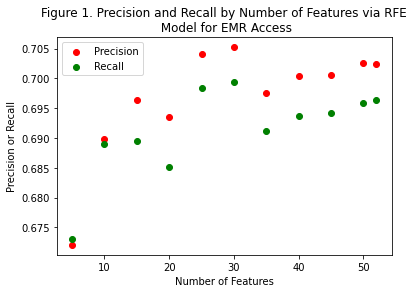

In [46]:
plt.scatter(data=df_ofracceith_rfe, x = 'Features', y = 'Precision', color = 'red', label = 'Precision')
plt.scatter(data=df_ofracceith_rfe, x = 'Features', y = 'Recall', color = 'green', label = 'Recall')
plt.legend()
plt.ylabel('Precision or Recall')
plt.xlabel('Number of Features')
plt.title('Figure 1. Precision and Recall by Number of Features via RFE\n Model for EMR Access');

It looks like with manual RFE we actually get better precision and recall at 30 features. This is also a more parsimonious model, so we'll use it.

Make new dataframes for the reduced set of variables. Also save the coefficients and predicted probabilities.
First, we need to run that model again though.

In [47]:
# run RFE with 30 features so we can get the model coefficients etc.
logregrfe = LogisticRegression(class_weight = 'balanced', C = 1, n_jobs = -1)
rfe = RFE(logregrfe, n_features_to_select = 30, verbose = 2)
# this X matrix contains only the 53 parameters identified by RFECV above
rfe.fit(X_train_ofracceith_rfe, Y_train_ofracceith_bin)
Y_predrfe1 = rfe.predict(X_train_ofracceith_rfe)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_ofracceith_bin, Y_predrfe1)
Y_predrfe2 = rfe.predict(X_test_ofracceith_rfe)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_ofracceith_bin, Y_predrfe2)

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
training set scores: 
confusion matrix:
 [[1407  665]
 [ 898 2520]]
precision: 0.72297; recall: 0.71530, accuracy: 0.71530
test set scores: 
confusion matrix:
 [[ 601  308]
 [ 392 1027]]
precision: 0.70523; r

In [48]:
# make a dataframe containing only the columns identified by the RFE model (30 features)
X_train_ofracceith_rfe_final = X_train_ofracceith_rfe.loc[:, rfe.support_]

In [49]:
# see which columns are left
X_train_ofracceith_rfe_final.columns

Index(['highspanli', 'useinternet', 'electronic_selfhealthinfo',
       'regularprovider', 'healthinsurance', 'everhadcancer',
       'healthins_pubpriv_2', 'selfgender_2', 'whruseinet_pubvother_1',
       'whruseinet_pubvother_2', 'survey_cycle_3', 'survey_cycle_4',
       'survey_cycle_5', 'ownabilitytakecarehealth_5', 'educa_4',
       'tablethealthwellnessapps_1', 'hhinc_1', 'maritalstatus_6', 'censdiv_6',
       'freqgoprovider_2', 'freqgoprovider_3', 'freqgoprovider_4',
       'freqgoprovider_5', 'freqgoprovider_6', 'tablet_discussionshcp_1',
       'agegrpb_4', 'qualitycare_1', 'qualitycare_2', 'raceethn5_4',
       'avgdrinks_cat_5'],
      dtype='object')

In [50]:
# repeat for test set
X_test_ofracceith_rfe_final = X_test_ofracceith_rfe.loc[:, rfe.support_]

In [51]:
# save the model coefficients
offeraccesseither_coefs = rfe.estimator_.coef_

In [52]:
# check the size; should be 30
offeraccesseither_coefs.shape

(1, 30)

In [53]:
# and the intercept
offeraccesseither_inters = rfe.estimator_.intercept_

In [54]:
# check the class order
rfe.estimator_.classes_

array([0, 1])

In [55]:
# get the predicted probabilities for the test set (for class 1/Yes)
offeraccesseither_probs = rfe.estimator_.predict_proba(X_test_ofracceith_rfe_final)[:, 1]

In [56]:
# check this; should be 1d array with 2328 entries
display(offeraccesseither_probs)
display(offeraccesseither_probs.shape)

array([0.32166654, 0.70921354, 0.07766182, ..., 0.7077601 , 0.45450252,
       0.54080091])

(2328,)

In [57]:
# check the spread of the predicted probabilities
print('max pred. probability:', offeraccesseither_probs.max())

max pred. probability: 0.9317538596179243


In [58]:
print('min pred. probability:', offeraccesseither_probs.min())

min pred. probability: 0.013339408148240271


There is a wide range of predicted probabilities in the test set. This will be useful in differentiating which respondents are more and less likely to have been offered access to an EMR.

<a id="sumfinvarsoae"></a>
#### Summary of Final Variables
Let's summarize the 30 variables left in the final model, and look at their coefficients. Since the outcome is coded as N = 0, Y =1 and all the features are positive integers, a positive coefficient implies that a respondent with the characteristic is more likely to be offered EMR access, and a negative coefficient, less likely.

In [59]:
# look at the list of variables with their logistic regression coefficients
col_list = list(X_train_ofracceith_rfe_final.columns)
for i in range(len(col_list)):
    print('Column: ', col_list[i], ' Coefficient: ', offeraccesseither_coefs[0, i])

Column:  highspanli  Coefficient:  -0.35927242348282507
Column:  useinternet  Coefficient:  0.5932368186548999
Column:  electronic_selfhealthinfo  Coefficient:  0.2894474257386204
Column:  regularprovider  Coefficient:  0.5084818065448264
Column:  healthinsurance  Coefficient:  0.7737278239917443
Column:  everhadcancer  Coefficient:  0.2906158753380574
Column:  healthins_pubpriv_2  Coefficient:  -0.3545778640835726
Column:  selfgender_2  Coefficient:  0.3896667095944338
Column:  whruseinet_pubvother_1  Coefficient:  0.2922562813804385
Column:  whruseinet_pubvother_2  Coefficient:  0.3009805372744603
Column:  survey_cycle_3  Coefficient:  0.3258140401324505
Column:  survey_cycle_4  Coefficient:  0.5348607034860925
Column:  survey_cycle_5  Coefficient:  0.4198055512910103
Column:  ownabilitytakecarehealth_5  Coefficient:  -0.42397994792191757
Column:  educa_4  Coefficient:  0.33157581588196716
Column:  tablethealthwellnessapps_1  Coefficient:  0.4495771512559374
Column:  hhinc_1  Coeffic

**Variables associated with higher likelihood of being offered EMR access:**  

_Demographic & Temporal:_
- `educa_4` : College or higher education (vs all other levels)
- `selfgender_2` : Female (vs male or no answer)
- `survey_cycle_3` : 2019 (vs 2018, 2020 pre- & post-pandemic)
- `survey_cycle_4` : 2020 pre-pandemic (vs 2018, 2019, 2020 post-pandemic)
- `survey_cycle_5` : 2020 post-pandemic (vs 2018, 2019, 2020 pre-pandemic)
- `agegrpb_4` : Age 65-74 (vs. all other age strata; highest is \>= 75)

_Health-Related:_
- `regularprovider` : Have regular HCP (vs do not)
- `healthinsurance` : Have some form of health insurance (vs do not)
- `everhadcancer` : Ever diagnosed with cancer (vs never)
- `qualitycare_1` : Rate quality of HCP's care "excellent" (vs. don't go, very good, good, fair, poor)
- `qualitycare_2` : Rate quality of HCP's care "very good" (vs. don't go, excellent, good, fair, poor)
- `freqgoprovider_2` : See HCP 2 times yearly (vs. 0, 1, 3, 4, 5-9, and >=10)
- `freqgoprovider_3` : See HCP 3 times yearly (vs. 0, 1, 2, 4, 5-9, and >=10)
- `freqgoprovider_4` : See HCP 4 times yearly (vs. 0, 1, 2, 3, 5-9, and >=10)
- `freqgoprovider_5` : See HCP 5-9 times yearly (vs. 0, 1, 2, 3, 4, and >=10)
- `freqgoprovider_6` : See HCP >= 10 times yearly (vs. 0, 1, 2, 3, 4, and 5-9)

_Electronic Device & Internet-Related:_
- `useinternet` : Use internet for web browsing/email (vs do not)
- `electronic_selfhealthinfo` : Have used electronic means to search for health-related info in last 12 mos (vs haven't)
- `whruseinet_pubvother_1` : Use internet in public place (eg library) "often" or "sometimes"(vs never or don't use internet)
- `whruseinet_pubvother_2` : Do not use internet in public place (eg library) (vs often/sometimes or don't use internet)
- `tablethealthwellnessapps_1` : Have health/wellness apps on a tablet (vs no  or don't own tablet)
- `tablet_discussionshcp_1` : Use tablet as aid for discussion with HCP (vs no  or don't own tablet)

**Variables associated with lower likelihood of being offered EMR access:**  

_Demographic:_
- `highspanli` : Linguistically isolated (high prevalence less proficient English speakers)
- `raceethn5_4` : Non-Hispanic Asian (vs all other racial groupings)
- `censdiv_6` : East South Central census division (KY, TN, MS, AL; vs all other divisions)
- `hhinc_1` : Household income in lowest category (\< \$20k/yr; vs all higher categories & not reported)
- `maritalstatus_6` : Single (vs all other categories)

_Health-Related:_
- `healthins_pubpriv_2` : Public insurance (Medicare/Medicaid) without employer-provided insurance (vs private/employer-provided or non)
- `avgdrinks_cat_5` : \>= 150\% of number drinks CDC classifies as heavy drinking (M \>= 23, F \>= 13; other: \>=18; this is highest category; vs all lower categories)
- `ownabilitytakecarehealth_5` : "Not at all" confident in own ability to take care of health (vs completely, very, somewhat, or a little confident)

We can also plot the odds ratios for each variable to get a graphical representation of the relative strength of each feature.

In [60]:
# calculate odds ratios
offeraccesseither_ORs = np.exp(offeraccesseither_coefs).reshape(30)

In [61]:
# check range
print('min OR: ', np.min(offeraccesseither_ORs))
print('max OR: ', np.max(offeraccesseither_ORs))

min OR:  0.6544370045992057
max OR:  2.167832507688576


In [62]:
# put the ORs and column labels in a df so it can be sorted
df_oae_OR = pd.DataFrame(columns = ['col', 'OR'])
df_oae_OR['col'] = col_list
df_oae_OR['OR'] = offeraccesseither_ORs

In [63]:
#sort
df_oae_OR.sort_values(by='OR', inplace = True)
df_oae_OR.head(10)

,col,OR
13,ownabilitytakecarehealth_5,0.654437
28,raceethn5_4,0.696672
0,highspanli,0.698184
6,healthins_pubpriv_2,0.701469
17,maritalstatus_6,0.735501
16,hhinc_1,0.747797
29,avgdrinks_cat_5,0.768708
18,censdiv_6,0.791935
25,agegrpb_4,1.322306
2,electronic_selfhealthinfo,1.335689


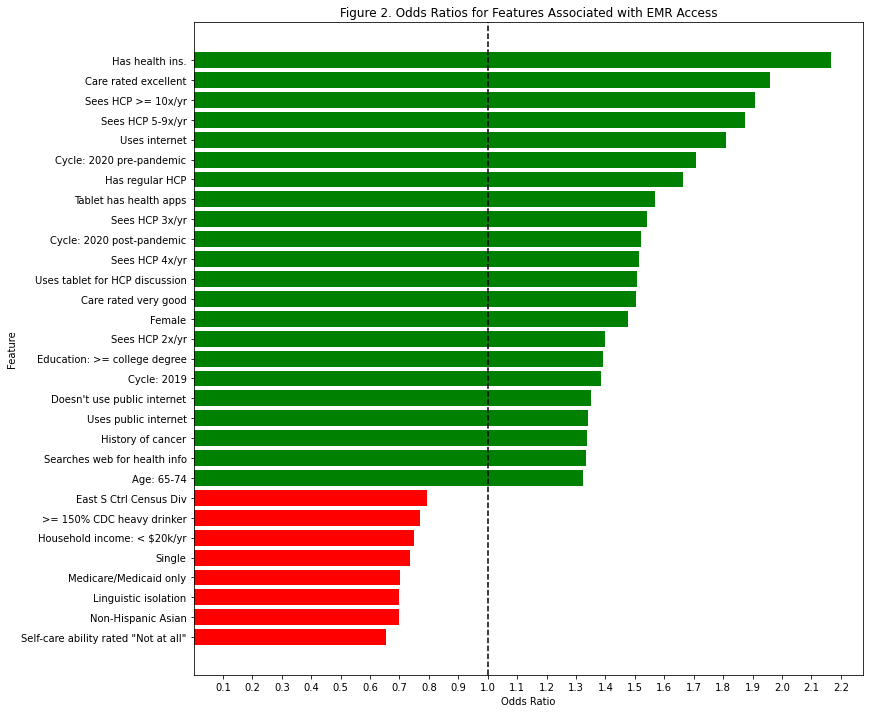

In [91]:
fig, bar1 = plt.subplots(figsize = (12,12)) 
y_labs = ['Self-care ability rated "Not at all"', 'Non-Hispanic Asian', 'Linguistic isolation', 'Medicare/Medicaid only',\
         'Single','Household income: < $20k/yr', '>= 150% CDC heavy drinker', 'East S Ctrl Census Div',\
         'Age: 65-74', 'Searches web for health info', 'History of cancer', 'Uses public internet',\
         "Doesn't use public internet", 'Cycle: 2019', 'Education: >= college degree', 'Sees HCP 2x/yr', 'Female',\
         'Care rated very good', 'Uses tablet for HCP discussion', 'Sees HCP 4x/yr', 'Cycle: 2020 post-pandemic',\
         'Sees HCP 3x/yr', 'Tablet has health apps', 'Has regular HCP', 'Cycle: 2020 pre-pandemic','Uses internet',\
         'Sees HCP 5-9x/yr', 'Sees HCP >= 10x/yr', 'Care rated excellent', 'Has health ins.']
df_oae_OR['ORlt1'] = df_oae_OR['OR'] < 1.0
bar1 = plt.barh(data=df_oae_OR, y=np.arange(30), width='OR', tick_label=y_labs,\
               color=df_oae_OR['ORlt1'].map({True:'r', False:'g'}))
plt.title('Figure 2. Odds Ratios for Features Associated with EMR Access')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.xticks(np.arange(0.1, 2.3, 0.1))
plt.axvline(x=1.0, color='black', linestyle='--');

In the figure, the dividing line at 1.0 demarcates features associated with EMR access (in green; odds ratio \> 1.0) and those not associated with EMR use (in red; odds ratio \< 1.0).  
Having insurance of any type is most strongly associated with being offered EMR access, followed by care rated "excellent". Female gender, higher educational attainment,  and older age are also significant. The only chronic condition with a significant effect is a history of cancer, although more frequent visits to an HCP are associated with higher likelihood of being offered access. Using the internet, as well as using it and e-devices for health-related purposes are also predictors. Finally, the 2019-2020 (versus 2018) survey cycles are associated with increased EMR access, with the highest weight for 2020 pre-pandemic, followed by 2020 post-pandemic, then 2019, indicating there is a time effect although perhaps not a linear one. 
By contrast, being "not at all confident" in one's ability to take care of one's health is most associated with _not_ been offered EMR access, followed by by Non-Hispanic Asian racial indentity. Being in the lowest income stratum, being single, having only Medicare and/or Medicaid, and residing in the East South Central census division or in a linguistically isolated area also associated with reduced access. No chronic condition appears, but very heavy drinking also predicts reduced access.

Another way to look at this is to assess differences in characteristics of those predicted to be highly likely and highly unlikely to be offered EMR access. Let's see what the probability distribution looks like.

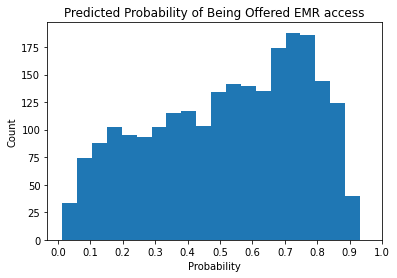

In [65]:
# plot the probability of being offered EMR access
plt.hist(x=offeraccesseither_probs, bins=20)
plt.xticks(np.arange(0.0, 1.1, step = 0.1))
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Predicted Probability of Being Offered EMR access');

The distribution tends to increase slightly between 0.2 and about 0.75, then tails off at high and low values.

In [66]:
print('N >= 90% probability:', offeraccesseither_probs[offeraccesseither_probs >= 0.90].shape[0])
print('N <= 10% probability:', offeraccesseither_probs[offeraccesseither_probs <= 0.10].shape[0])

N >= 90% probability: 18
N <= 10% probability: 92


Relatively few predictions are at the high end (\>= 90%). Let's widen the range.

In [67]:
print('N >= 80% probability:', offeraccesseither_probs[offeraccesseither_probs >= 0.80].shape[0])
print('N <= 20% probability:', offeraccesseither_probs[offeraccesseither_probs <= 0.20].shape[0])

N >= 80% probability: 288
N <= 20% probability: 302


This range gives better balance between those with higher and lower predicted probabilities.

We want to look at characteristics of respondents in the high and low probability groups. For this, it will be useful to have a dataframe with the probabilities added on to the X matrix.

In [68]:
# append probabilities to the final X matrix
X_test_ofracceith_finprobs =  pd.concat([X_test_ofracceith_rfe_final, pd.Series(offeraccesseither_probs)], axis = 1)

In [69]:
# check it
display(X_test_ofracceith_finprobs.head())
display(X_test_ofracceith_finprobs.shape)

,highspanli,useinternet,electronic_selfhealthinfo,regularprovider,healthinsurance,everhadcancer,healthins_pubpriv_2,selfgender_2,whruseinet_pubvother_1,whruseinet_pubvother_2,...,freqgoprovider_4,freqgoprovider_5,freqgoprovider_6,tablet_discussionshcp_1,agegrpb_4,qualitycare_1,qualitycare_2,raceethn5_4,avgdrinks_cat_5,0
0,0,1,1,0,1,0,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0.321667
1,0,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0.709214
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.077662
3,0,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0.712465
4,0,1,1,1,1,0,0,1,0,1,...,0,0,1,1,0,1,0,0,0,0.875654


(2328, 31)

In [70]:
# rename the probability column
X_test_ofracceith_finprobs.rename(columns = {0:"pred_proba"}, inplace = True)
display(X_test_ofracceith_finprobs.columns)

Index(['highspanli', 'useinternet', 'electronic_selfhealthinfo',
       'regularprovider', 'healthinsurance', 'everhadcancer',
       'healthins_pubpriv_2', 'selfgender_2', 'whruseinet_pubvother_1',
       'whruseinet_pubvother_2', 'survey_cycle_3', 'survey_cycle_4',
       'survey_cycle_5', 'ownabilitytakecarehealth_5', 'educa_4',
       'tablethealthwellnessapps_1', 'hhinc_1', 'maritalstatus_6', 'censdiv_6',
       'freqgoprovider_2', 'freqgoprovider_3', 'freqgoprovider_4',
       'freqgoprovider_5', 'freqgoprovider_6', 'tablet_discussionshcp_1',
       'agegrpb_4', 'qualitycare_1', 'qualitycare_2', 'raceethn5_4',
       'avgdrinks_cat_5', 'pred_proba'],
      dtype='object')

In [71]:
# Get the top 10 categories by %age for predict probability >= 80 and <= 20
# denominators for %age
N_oae_80 = offeraccesseither_probs[offeraccesseither_probs >= 0.80].shape[0]
N_oae_20 = offeraccesseither_probs[offeraccesseither_probs <= 0.20].shape[0]

In [72]:
# list of columns
oae_cols = list(X_test_ofracceith_finprobs.columns)
oae_cols.remove('pred_proba')

In [73]:
# make a df for the results
df_oae_pcts = pd.DataFrame(index = oae_cols, columns = ['pct_ge80', 'pct_le20'])

In [74]:
# check structure of df
df_oae_pcts.head()

,pct_ge80,pct_le20
highspanli,NaN,NaN
useinternet,NaN,NaN
electronic_selfhealthinfo,NaN,NaN
regularprovider,NaN,NaN
healthinsurance,NaN,NaN


In [75]:
# get the %age of each variable in the prob >= 80 and prob <= 20 groups
for col in oae_cols:
    df_oae_pcts.loc[col, 'pct_ge80'] = X_test_ofracceith_finprobs[col][X_test_ofracceith_finprobs['pred_proba'] >= 0.80].sum()/(0.01*N_oae_80)    
    df_oae_pcts.loc[col, 'pct_le20'] = X_test_ofracceith_finprobs[col][X_test_ofracceith_finprobs['pred_proba'] <= 0.20].sum()/(0.01*N_oae_20)

In [76]:
# check it
df_oae_pcts.head()

,pct_ge80,pct_le20
highspanli,2.430556,20.198675
useinternet,100.0,36.754967
electronic_selfhealthinfo,97.916667,28.807947
regularprovider,97.916667,35.430464
healthinsurance,100.0,78.476821


In [77]:
# get top 10 for those with >= 80% probability
df_top80 = df_oae_pcts.sort_values(by='pct_ge80', ascending=False).head(10)

In [78]:
df_top80

,pct_ge80,pct_le20
healthinsurance,100.0,78.476821
useinternet,100.0,36.754967
electronic_selfhealthinfo,97.916667,28.807947
regularprovider,97.916667,35.430464
tablethealthwellnessapps_1,90.277778,7.94702
educa_4,85.763889,12.913907
selfgender_2,80.902778,34.10596
whruseinet_pubvother_2,80.208333,29.139073
tablet_discussionshcp_1,80.208333,4.304636
qualitycare_1,61.805556,8.940397


In [79]:
# get top 10 for those with <= 20% probability
df_top20 = df_oae_pcts.sort_values(by='pct_le20', ascending=False).head(10)

In [80]:
df_top20

,pct_ge80,pct_le20
healthinsurance,100.0,78.476821
healthins_pubpriv_2,16.319444,50.0
hhinc_1,1.041667,43.377483
survey_cycle_3,40.625,37.417219
useinternet,100.0,36.754967
regularprovider,97.916667,35.430464
selfgender_2,80.902778,34.10596
whruseinet_pubvother_2,80.208333,29.139073
electronic_selfhealthinfo,97.916667,28.807947
maritalstatus_6,5.208333,26.821192


Based on those results, it looks like finding the variables with the largest difference between the two groups might be more useful.

In [81]:
# find difference in percentages
df_oae_pcts['diff'] = df_oae_pcts['pct_ge80'] - df_oae_pcts['pct_le20']
# but we'll want to sort by the absolute difference
df_oae_pcts['absdiff'] = np.abs(df_oae_pcts['diff'])

In [82]:
df_oae_pcts.head()

,pct_ge80,pct_le20,diff,absdiff
highspanli,2.430556,20.198675,-17.76812,17.76812
useinternet,100.0,36.754967,63.245033,63.245033
electronic_selfhealthinfo,97.916667,28.807947,69.10872,69.10872
regularprovider,97.916667,35.430464,62.486203,62.486203
healthinsurance,100.0,78.476821,21.523179,21.523179


In [83]:
df_topabs = df_oae_pcts.sort_values(by='absdiff', ascending=False).head(10)

In [84]:
df_topabs

,pct_ge80,pct_le20,diff,absdiff
tablethealthwellnessapps_1,90.277778,7.94702,82.330758,82.330758
tablet_discussionshcp_1,80.208333,4.304636,75.903698,75.903698
educa_4,85.763889,12.913907,72.849982,72.849982
electronic_selfhealthinfo,97.916667,28.807947,69.10872,69.10872
useinternet,100.0,36.754967,63.245033,63.245033
regularprovider,97.916667,35.430464,62.486203,62.486203
qualitycare_1,61.805556,8.940397,52.865158,52.865158
whruseinet_pubvother_2,80.208333,29.139073,51.06926,51.06926
selfgender_2,80.902778,34.10596,46.796818,46.796818
hhinc_1,1.041667,43.377483,-42.335817,42.335817


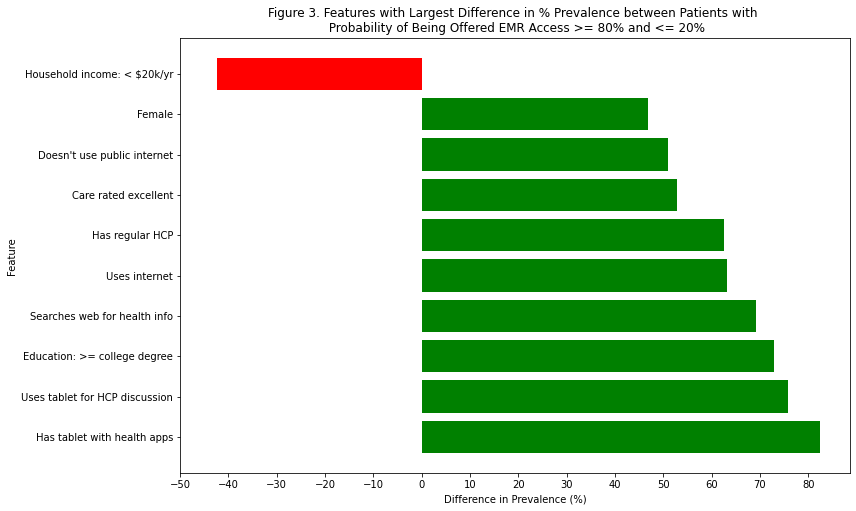

In [85]:
fig, bar2 = plt.subplots(figsize = (12,8))
y_labs = ['Has tablet with health apps', 'Uses tablet for HCP discussion', 'Education: >= college degree', \
          'Searches web for health info', 'Uses internet', 'Has regular HCP', 'Care rated excellent', \
         "Doesn't use public internet", 'Female', 'Household income: < $20k/yr']
df_topabs['negpos'] = df_topabs['diff'] < 0
bar2 = plt.barh(data=df_topabs, y=np.arange(10), width='diff', tick_label=y_labs,\
               color=df_topabs['negpos'].map({True:'r', False:'g'}))
plt.title('Figure 3. Features with Largest Difference in % Prevalence between Patients with \n Probability of Being Offered EMR Access >= 80% and <= 20%')
plt.xlabel('Difference in Prevalence (%)')
plt.ylabel('Feature')
plt.xticks(np.arange(-50, 90, 10));

In the above figure, the 10 features with the biggest difference in prevalence between predicted probabilities of \>= 80% and \<= 20% of being offered access to an EMR are shown.  
Red bars indicate features more prevalent in patients with predicted probability \<= 20% of being offered EMR access. The only variable in the top 10 more prevalent in this group is being in the lowest household income stratum (\< \$20,000/yr).  
Green bars indicate features more prevalent in patients with predicted probability \>= 80% of being offered EMR access. Demographically, these patients are more likely to be female and have at least a college degree. Medically, they are  more likely to have a regular HCP and to give the highest rating (excellent) to the quality of the HCP's care. The rest of the variables relate to internet access and use: they are more likely to use the internet, but less likely to do so via public access (e.g. a library). They are more likely to use the internet and a device like a tablet to look for health information, monitor their health, and have discussions with their HCP.

<a id="modelaor"></a>
### Model for `accessonlinerecord` Outcome

This outcome variable denotes how frequently a respondent has used an EMR access in the past 12 months. The categories are "None" (which includes those who don't have access to an EMR), 1-2 times, 3-5 times, 6-9 times, and \>= 10 times. Our preliminary decision was to maintain all the categories, to see if we can gain insight into differences between less and more frequent users. However, this many categories may give us trouble with accurate classification, as it did with the previous outcome variable.

Make the X and Y matrices for this outcome variable.

In [86]:
X_train_acconlrec = df_train_dums.drop(columns = ['offeredaccesseither', 'accessonlinerecord'])
X_test_acconlrec = df_test_dums.drop(columns = ['offeredaccesseither', 'accessonlinerecord'])

In [87]:
# check the columns
X_train_acconlrec.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 109 columns):
 #    Column                        Dtype
---   ------                        -----
 0    highspanli                    int64
 1    useinternet                   int64
 2    electronic_selfhealthinfo     int64
 3    intrsn_visitedsocnet          int64
 4    intrsn_sharedsocnet           int64
 5    intrsn_supportgroup           int64
 6    intrsn_youtube                int64
 7    regularprovider               int64
 8    healthinsurance               int64
 9    medconditions_diabetes        int64
 10   medconditions_highbp          int64
 11   medconditions_heartcondition  int64
 12   medconditions_depression      int64
 13   everhadcancer                 int64
 14   wkminmodex_cat_2              uint8
 15   wkminmodex_cat_3              uint8
 16   wkminmodex_cat_4              uint8
 17   wkminmodex_cat_5              uint8
 18   healthins_pubpriv_2           uint8
 19   heal

In [88]:
# make the Y matrices
Y_train_acconlrec = df_train_dums['accessonlinerecord']
Y_test_acconlrec = df_test_dums['accessonlinerecord']

<a id="prelimmodelaor"></a>
#### Preliminary model

The approach will be the same as with the other outcome variable: we'll use logistic regression, with RFECV to reduce the size of the feature set. Categories 3 and 4 are rare, so balanced class weights will again be used, as will F1 scoring.

In [89]:
# fit the model using recursive feature elimination and logistic regression
logreg5 = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', C = 1, n_jobs = -1)
model3 = RFECV(logreg5, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
model3.fit(X_train_acconlrec, Y_train_acconlrec)
Y_pred9 = model3.predict(X_train_acconlrec)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_acconlrec, Y_pred9)
Y_pred10 = model3.predict(X_test_acconlrec)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_acconlrec, Y_pred10)

Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
training set score

RFECV reduces the size from 109 to 82 features, but the fit is very poor (recall < 0.5). There is not a major difference between training and test sets to indicate overfitting. 

<a id="tunemodelaor"></a>
#### Model Tuning
We'll also try to tune this, though if the previous results are any indication, it is unlikely to significantly improve. Because the classes are more imbalanced here, we won't bother trying "None" for weighting. Instead, we'll expand the range of `C`. 

In [90]:
# tune the multinomial LR model
# will leave class weight as balanced here since latter categories are rare
# expand range of C to see if that makes any difference
parameters2 = [
    {                                
                'estimator__C':  [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10], 
                'step': [1, 3, 5],
    }]
logreg6 = LogisticRegression(class_weight = 'balanced', multi_class = 'multinomial', n_jobs = -1)
rfecv3 = RFECV(logreg6, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
clf3 = GridSearchCV(rfecv3, parameters2, n_jobs = -1, verbose = 2)
clf3.fit(X_train_acconlrec, Y_train_acconlrec)
Y_pred11 = clf3.predict(X_train_acconlrec)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_acconlrec, Y_pred11)
Y_pred12 = clf3.predict(X_test_acconlrec)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_acconlrec, Y_pred12)
print("\nBest Parameters:", clf3.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
  warnings.warn(


Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
training set scores: 
confusion matrix:
 [[2334  402   66   69  325]
 [ 374  230   65   50  246]
 [ 220  134   73   57  279]
 [  83   30   18   38  127]
 [  53   11   11   11  184]]
precision: 0.55399; recall: 0.52077, accuracy: 0.52077
test set scores: 
confusion matrix:
 [[994 187  39  27 151]
 [142 103  32  22 110]
 [ 89  44  17  32 100]
 [ 33  11   8  14  49]
 [ 27   5   7  10  75]]
precision: 0.55104; recall: 0.51675, accuracy: 0.51675

Best Parameters: {'estimator__C': 1e-05, 'step': 1}


Recall improves slightly with parameter tuning, but precision is worse, and both are still very low. There are also 17 more features. As with the previous analysis, this is likely due to trying to fit the rare classes. 

<a id="binmodelaor"></a>
#### Binarizing the Outcome  
As we did with the previous variable, we can combine categories. Overall, the most important division is between those who never used the EMR and those who did use it. So, let's make a binary outcome variable with "never used" vs "ever used".

In [92]:
# reclassify as "never used" (0) vs "ever used" (1)
Y_train_acconlrec_bin = Y_train_acconlrec
Y_train_acconlrec_bin.loc[Y_train_acconlrec > 1] = 1

/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [93]:
# check it reclassified correctly
Y_train_acconlrec_bin.value_counts()

0    3196
1    2294
Name: accessonlinerecord, dtype: int64

In [94]:
# repeat for test set
Y_test_acconlrec_bin = Y_test_acconlrec
Y_test_acconlrec_bin.loc[Y_test_acconlrec > 1] = 1

/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [95]:
# fit a LR model to the binary outcome variable
logreg7 = LogisticRegression(class_weight = 'balanced', C = 1, n_jobs = -1)
model4 = RFECV(logreg7, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
model4.fit(X_train_acconlrec, Y_train_acconlrec_bin)
Y_pred13 = model4.predict(X_train_acconlrec)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_acconlrec_bin, Y_pred13)
Y_pred14 = model4.predict(X_test_acconlrec)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_acconlrec_bin, Y_pred14)

Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator 

This model has 62 features. Consolidating the outcome variable to binary results in a large improvement in precision and recall, with the fomer increasing by ~0.15 and the latter by > 0.2 from the better of the two mutliclass models.


<a id="tunebinmodelaor"></a>
#### Tuning the Binary Model
Let's see if it improves further with tuning. We'll use the same parameter grid as we used for the multinomial model. 

In [96]:
# tune the binary LR model
# will use same parameter grid as for multinomial.
logreg8 = LogisticRegression(class_weight = 'balanced', n_jobs = -1)
rfecv4 = RFECV(logreg8, scoring = 'f1_weighted', verbose = 2, n_jobs = -1)
clf4 = GridSearchCV(rfecv4, parameters2, n_jobs = -1, verbose = 2)
clf4.fit(X_train_acconlrec, Y_train_acconlrec_bin)
Y_pred15 = clf4.predict(X_train_acconlrec)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_acconlrec_bin, Y_pred15)
Y_pred16 = clf4.predict(X_test_acconlrec)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_acconlrec_bin, Y_pred16)
print("\nBest Parameters:", clf4.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


/home/umahp/data_science/DSND/FinalProject/dsfinenv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]
  warnings.warn(


Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator 

This tuned model has fewer features (54 vs 62), but the precision and accuracy are noticeably worse, both by ~0.04. We'll stick with the original model.

In [97]:
# make a dataframe containing only the columns identified by the initial binary model (62 features)
X_train_acconlrec_rfe = X_train_acconlrec.loc[:, model4.support_]

In [98]:
# see which columns are left
X_train_acconlrec_rfe.columns

Index(['highspanli', 'useinternet', 'electronic_selfhealthinfo',
       'intrsn_visitedsocnet', 'intrsn_supportgroup', 'regularprovider',
       'healthinsurance', 'medconditions_diabetes', 'everhadcancer',
       'healthins_pubpriv_2', 'healthins_pubpriv_3', 'selfgender_2',
       'selfgender_3', 'whruseinet_pubvother_1', 'whruseinet_pubvother_2',
       'internet_broadbnd_1', 'survey_cycle_3', 'survey_cycle_4',
       'survey_cycle_5', 'ownabilitytakecarehealth_5', 'educa_2', 'educa_3',
       'educa_4', 'tablethealthwellnessapps_1', 'hhinc_1', 'hhinc_2',
       'hhinc_4', 'hhinc_5', 'nchsurcode2013_4', 'nchsurcode2013_5',
       'nchsurcode2013_6', 'phq4_cat_4', 'maritalstatus_3', 'maritalstatus_5',
       'censdiv_2', 'censdiv_3', 'censdiv_6', 'censdiv_8', 'censdiv_9',
       'smokestat_2', 'smokestat_3', 'freqgoprovider_2', 'freqgoprovider_3',
       'freqgoprovider_4', 'freqgoprovider_5', 'freqgoprovider_6',
       'generalhealth_4', 'generalhealth_5', 'tablet_discussionshcp_1',


In [99]:
# repeat for test set
X_test_acconlrec_rfe = X_test_acconlrec.loc[:, model4.support_]

<a id="manfeatreductaor"></a>
#### Manual Feature Reduction
As with the other outcome variable, we still have a large model despite pruning with RFECV. Let's try manual RFE pruning again.

In [100]:
# make a datframe to hold the results. we already have the column names defined
df_acconlrec_rfe = pd.DataFrame(columns = col_names)

In [101]:
# add the baseline model
df_acconlrec_rfe.loc[0, 'Features'] = 62
df_acconlrec_rfe.loc[0, 'Precision'] = 0.74122
df_acconlrec_rfe.loc[0, 'Recall'] = 0.72380

In [102]:
# do RFE with manual thresholds for number of parameters to keep
# C = 1 and balanced class weights worked well before, so keep them
RFE_cuts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
for i in range(len(RFE_cuts)):
    # use RFE to fit the model
    logregrfe = LogisticRegression(class_weight = 'balanced', C = 1, n_jobs = -1)
    rfe = RFE(logregrfe, n_features_to_select = RFE_cuts[i], verbose = 2)
    # this X matrix contains only the 62 parameters identified by RFECV above
    rfe.fit(X_train_acconlrec_rfe, Y_train_acconlrec_bin)
    Y_predrfe1 = rfe.predict(X_train_acconlrec_rfe)
    print('training set scores: ')
    prec, rec, acc = get_scores(Y_train_acconlrec_bin, Y_predrfe1)
    Y_predrfe2 = rfe.predict(X_test_acconlrec_rfe)
    print('test set scores: ')
    prec, rec, acc = get_scores(Y_test_acconlrec_bin, Y_predrfe2)
    # save the parameters to plot
    df_acconlrec_rfe.loc[i+1, 'Features'] = RFE_cuts[i]
    df_acconlrec_rfe.loc[i+1, 'Precision'] = prec
    df_acconlrec_rfe.loc[i+1, 'Recall'] = rec

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 fe

Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 fe

Plot the precision & recall results

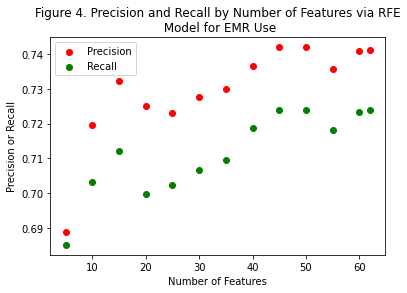

In [103]:
plt.scatter(data=df_acconlrec_rfe, x = 'Features', y = 'Precision', color = 'red', label = 'Precision')
plt.scatter(data=df_acconlrec_rfe, x = 'Features', y = 'Recall', color = 'green', label = 'Recall')
plt.legend()
plt.ylabel('Precision or Recall')
plt.xlabel('Number of Features')
plt.title('Figure 4. Precision and Recall by Number of Features via RFE\n Model for EMR Use');

For this model, the best results are at 45 and 50 features (slightly better than 60 and the RFECV-defined 62). We'll keep the most parsimonious model with 45 features.

Re-run the model with 45 features, then get the reduced datasets, coefficients, and probabilities.

In [104]:
# run RFE with 45 features so we can get the model coefficients etc.
logregrfe = LogisticRegression(class_weight = 'balanced', C = 1, n_jobs = -1)
rfe = RFE(logregrfe, n_features_to_select = 45, verbose = 2)
# this X matrix contains only the 45 parameters identified by RFECV above
rfe.fit(X_train_acconlrec_rfe, Y_train_acconlrec_bin)
Y_predrfe1 = rfe.predict(X_train_acconlrec_rfe)
print('training set scores: ')
prec, rec, acc = get_scores(Y_train_acconlrec_bin, Y_predrfe1)
Y_predrfe2 = rfe.predict(X_test_acconlrec_rfe)
print('test set scores: ')
prec, rec, acc = get_scores(Y_test_acconlrec_bin, Y_predrfe2)

Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
training set scores: 
confusion matrix:
 [[2243  953]
 [ 499 1795]]
precision: 0.74915; recall: 0.73552, accuracy: 0.73552
test set scores: 
confusion matrix:
 [[968 430]
 [213 717]]
precision: 0.74193; recall: 0.72380, accuracy: 0.72380


In [105]:
# make a dataframe containing only the columns identified by the RFE model (45 features)
X_train_acconlrec_rfe_final = X_train_acconlrec_rfe.loc[:, rfe.support_]

In [106]:
# see which columns are left
X_train_acconlrec_rfe_final.columns

Index(['highspanli', 'useinternet', 'electronic_selfhealthinfo',
       'intrsn_visitedsocnet', 'regularprovider', 'healthinsurance',
       'medconditions_diabetes', 'everhadcancer', 'selfgender_2',
       'whruseinet_pubvother_1', 'whruseinet_pubvother_2',
       'internet_broadbnd_1', 'survey_cycle_3', 'survey_cycle_4',
       'survey_cycle_5', 'ownabilitytakecarehealth_5', 'educa_2', 'educa_3',
       'educa_4', 'tablethealthwellnessapps_1', 'hhinc_1', 'hhinc_2',
       'nchsurcode2013_4', 'nchsurcode2013_5', 'phq4_cat_4', 'maritalstatus_5',
       'censdiv_2', 'censdiv_6', 'censdiv_8', 'censdiv_9', 'smokestat_2',
       'smokestat_3', 'freqgoprovider_3', 'freqgoprovider_4',
       'freqgoprovider_5', 'freqgoprovider_6', 'tablet_discussionshcp_1',
       'qualitycare_1', 'qualitycare_2', 'qualitycare_3', 'qualitycare_4',
       'qualitycare_5', 'raceethn5_3', 'avgdrinks_cat_4', 'havedevice_cat_5'],
      dtype='object')

In [107]:
# repeat for test set
X_test_acconlrec_rfe_final = X_test_acconlrec_rfe.loc[:, rfe.support_]

In [108]:
# save the model coefficients
accessonlinerec_coefs = rfe.estimator_.coef_

In [109]:
accessonlinerec_coefs.shape

(1, 45)

In [110]:
# and the intercept
accessonlinerec_inters = rfe.estimator_.intercept_

In [111]:
# check the order of classes
rfe.estimator_.classes_

array([0, 1])

In [112]:
# get the predicted probabilities for the test set (for class 1/Yes)
accessonlinerec_probs = rfe.estimator_.predict_proba(X_test_acconlrec_rfe_final)[:, 1]

In [113]:
# check this; should be 1d array with 2328 entries
display(accessonlinerec_probs)
display(accessonlinerec_probs.shape)

array([0.36688057, 0.46907124, 0.05637257, ..., 0.66076884, 0.23319155,
       0.7368352 ])

(2328,)

In [114]:
# check the spread of the predicted probabilities
print('max pred. probability:', accessonlinerec_probs.max())

max pred. probability: 0.9710017339140594


In [115]:
print('min pred. probability:', accessonlinerec_probs.min())

min pred. probability: 0.0020900136452460995


There is again a wide range of predicted probabilities in the test set. This will be useful in differentiating which respondents are more and less likely to have been used an EMR.

<a id="sumfinvarsaor"></a>
#### Summary of Final Variables
We'll summarize the 45 variables left in the final model, along with their influence as we did above. Again, the outcome is coded as N = 0, Y =1 and all the features are positive integers, so a positive coefficient implies that a respondent with the characteristic is more likely to have used an EMR, and a negative coefficient, less likely.

In [116]:
# look at the list of variables with their logistic regression coefficients
col_list = list(X_train_acconlrec_rfe_final.columns)
for i in range(len(col_list)):
    print('Column: ', col_list[i], ' Coefficient: ', accessonlinerec_coefs[0, i])

Column:  highspanli  Coefficient:  -0.5314232058184372
Column:  useinternet  Coefficient:  0.5959222073506646
Column:  electronic_selfhealthinfo  Coefficient:  0.6964149012211505
Column:  intrsn_visitedsocnet  Coefficient:  0.2942769985852222
Column:  regularprovider  Coefficient:  0.5968813880259547
Column:  healthinsurance  Coefficient:  0.6597592075166226
Column:  medconditions_diabetes  Coefficient:  0.3192491976140931
Column:  everhadcancer  Coefficient:  0.22935447833534311
Column:  selfgender_2  Coefficient:  0.22429251947206041
Column:  whruseinet_pubvother_1  Coefficient:  0.31748937633004637
Column:  whruseinet_pubvother_2  Coefficient:  0.2784328310206265
Column:  internet_broadbnd_1  Coefficient:  0.2678436165094574
Column:  survey_cycle_3  Coefficient:  0.3055187314354836
Column:  survey_cycle_4  Coefficient:  0.6426305100413843
Column:  survey_cycle_5  Coefficient:  0.4658477595940592
Column:  ownabilitytakecarehealth_5  Coefficient:  -0.43855027130954677
Column:  educa_2

**Variables associated with higher likelihood of having used an EMR:**  

_Demographic & Temporal:_  
- `educa_2` : High school education (vs all other levels; lowest/reference is \< high school)
- `educa_3` : Some college education (vs all other levels)
- `educa_4` : College or higher education (vs all other levels)
- `selfgender_2` : Female (vs male or no answer)
- `censdiv_9` : Pacific census division (CA, OR, WA, AK, HI; vs all other divisions)
- `survey_cycle_3` : 2019 (vs 2018, 2020 pre- & post-pandemic)
- `survey_cycle_4` : 2020 pre-pandemic (vs 2018, 2019, 2020 post-pandemic)
- `survey_cycle_5` : 2020 post-pandemic (vs 2018, 2019, 2020 pre-pandemic)

_Health-Related:_  
- `regularprovider` : Have regular HCP (vs do not)
- `healthinsurance` : Have some form of health insurance (vs do not)
- `medconditions_diabetes` : Ever diagnosed with diabetes (vs never)
- `everhadcancer` : Ever diagnosed with cancer (vs never)
- `qualitycare_1` : Rate quality of HCP's care "excellent" (vs. don't go, very good, good, fair, poor)
- `qualitycare_2` : Rate quality of HCP's care "very good" (vs. don't go, excellent, good, fair, poor)
- `qualitycare_3` : Rate quality of HCP's care "good" (vs. don't go, excellent, very good, fair, poor)
- `qualitycare_4` : Rate quality of HCP's care "fair" (vs. don't go, excellent, very good, good, poor)
- `qualitycare_5` : Rate quality of HCP's care "poor" (vs. don't go, excellent, very good, good, fair)
- `freqgoprovider_3` : See HCP 3 times yearly (vs. 0, 1, 2, 4, 5-9, and >=10)
- `freqgoprovider_4` : See HCP 4 times yearly (vs. 0, 1, 2, 3, 5-9, and >=10)
- `freqgoprovider_5` : See HCP 5-9 times yearly (vs. 0, 1, 2, 3, 4, and >=10)
- `freqgoprovider_6` : See HCP >= 10 times yearly (vs. 0, 1, 2, 3, 4, and 5-9)
- `smokestat_2` : Former smoker (vs current, never)
- `smokestat_3` : Never smoker (vs current, former)


_Electronic Device & Internet-Related:_
- `useinternet` : Use internet for web browsing/email (vs do not)
- `electronic_selfhealthinfo` : Have used electronic means to search for health-related info in last 12 mos (vs haven't)
- `intrsn_visitedsocnet` : Used internet to visit social network (vs no or don't browse)
- `whruseinet_pubvother_1` : Use internet in public place (eg library) "often" or "sometimes" (vs never or don't use internet)
- `whruseinet_pubvother_2` : Do not use internet in public place (eg library) (vs often/sometimes or don't use internet)
- `tablethealthwellnessapps_1` : Have health/wellness apps on a tablet (vs no  or don't own tablet)
- `tablet_discussionshcp_1` : Use tablet as aid for discussion with HCP (vs no  or don't own tablet)
- `havedevice_cat_5` : Have multiple electronic devices (cell phone, regular phone, tablet; vs none or one of these)
- `internet_broadbnd_1` : Access the internet through a broadband connection (vs. don't or no internet)

**Variables associated with lower likelihood of having used an EMR:**  

_Demographic:_
- `highspanli` : Linguistically isolated (high prevalence less proficient English speakers)
- `raceethn5_3` : Hispanic (vs all other racial groupings)
- `censdiv_2`: Middle Atlantic census division (NJ, NY, PA; vs all other divisions)
- `censdiv_6` : East South Central census divsion (KY, TN, MS, AL; vs all other divisions)
- `censdiv_8` : Mountain census divsion (AZ, CO, ID, NM, MT, UT, NV, WY; vs all other divisions)
- `nchsurcode2013_4` : Metropolitan: small metro urban vs rural classification (4th smallest of 6; vs all other classifications)
- `nchsurcode2013_5` : Non-metropolitan: micropolitan urban vs rural classification (5th smallest of 6; vs all other classifications)
- `hhinc_1` : Household income in lowest category (\< \$20k/yr; vs all higher categories & not reported)
- `hhinc_2` : Household income in second-lowest category (\$20-34.99k/yr; vs all other categories & not reported)
- `maritalstatus_5` : Separated (vs all other categories)

_Health-Related:_
- `phq4_cat_4` : Severe psychological distress based on PHQ-4 score (vs none, mild, or moderate)
- `avgdrinks_cat_4` : \>= 100% to \< 150%  of number drinks CDC classifies as heavy drinking (M: 15-22, F: 8-12; missing: 12-17; this is second-highest category; vs other categories)
- `ownabilitytakecarehealth_5` : "Not at all" confident in own ability to take care of health (vs completely, very, somewhat, or a little confident)

Plot the odds ratios.

In [117]:
# calculate odds ratios
accessonlinerec_ORs = np.exp(accessonlinerec_coefs).reshape(45)

In [118]:
# check range
print('min OR: ', np.min(accessonlinerec_ORs))
print('max OR: ', np.max(accessonlinerec_ORs))

min OR:  0.572531171790117
max OR:  2.6467513735804555


In [119]:
# put the ORs and column labels in a df so it can be sorted
df_aor_OR = pd.DataFrame(columns = ['col', 'OR'])
df_aor_OR['col'] = col_list
df_aor_OR['OR'] = accessonlinerec_ORs

In [120]:
#sort
df_aor_OR.sort_values(by='OR', inplace = True)
df_aor_OR.head(10)

,col,OR
27,censdiv_6,0.572531
0,highspanli,0.587768
25,maritalstatus_5,0.632705
15,ownabilitytakecarehealth_5,0.644971
20,hhinc_1,0.676738
28,censdiv_8,0.696199
24,phq4_cat_4,0.709656
26,censdiv_2,0.747977
21,hhinc_2,0.752730
23,nchsurcode2013_5,0.772375


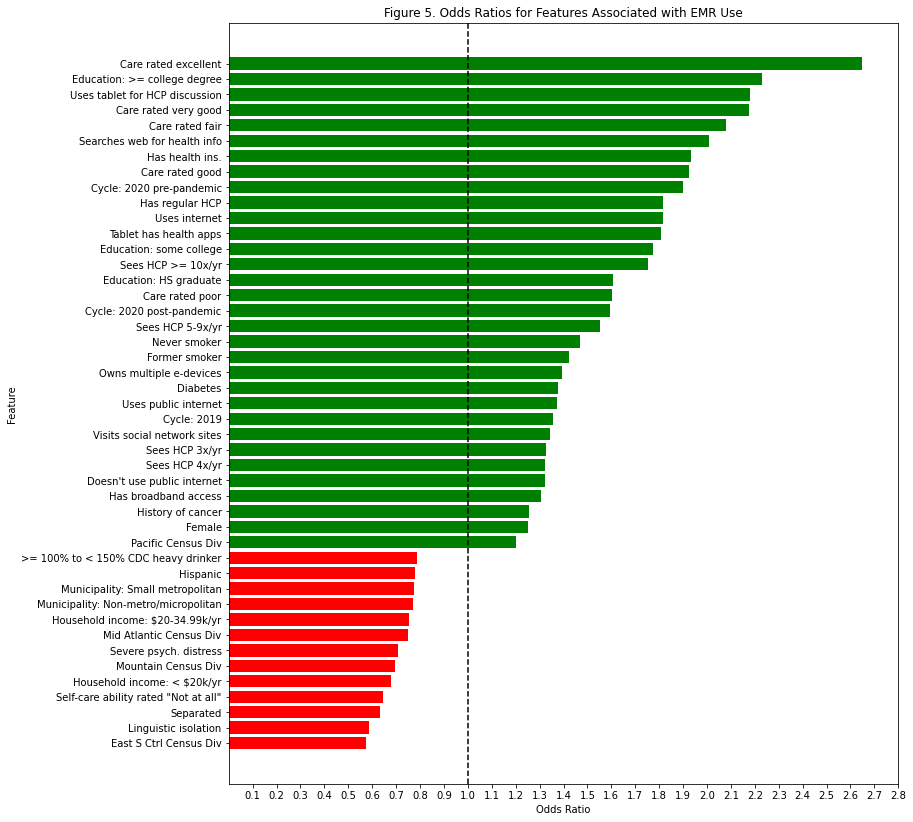

In [136]:
# plot the ORs
fig, bar3 = plt.subplots(figsize = (12,14)) 
y_labs = ['East S Ctrl Census Div', 'Linguistic isolation', 'Separated', 'Self-care ability rated "Not at all"',\
         'Household income: < $20k/yr', 'Mountain Census Div', 'Severe psych. distress', 'Mid Atlantic Census Div',\
         'Household income: $20-34.99k/yr', 'Municipality: Non-metro/micropolitan', 'Municipality: Small metropolitan',  \
         'Hispanic', '>= 100% to < 150% CDC heavy drinker', 'Pacific Census Div', 'Female', 'History of cancer',\
         'Has broadband access', "Doesn't use public internet", 'Sees HCP 4x/yr', 'Sees HCP 3x/yr',\
         'Visits social network sites', 'Cycle: 2019', 'Uses public internet', 'Diabetes', 'Owns multiple e-devices',\
         'Former smoker', 'Never smoker', 'Sees HCP 5-9x/yr', 'Cycle: 2020 post-pandemic', 'Care rated poor',\
         'Education: HS graduate', 'Sees HCP >= 10x/yr', 'Education: some college', 'Tablet has health apps',\
         'Uses internet', 'Has regular HCP', 'Cycle: 2020 pre-pandemic', 'Care rated good', 'Has health ins.',\
         'Searches web for health info', 'Care rated fair', 'Care rated very good', 'Uses tablet for HCP discussion',\
         'Education: >= college degree', 'Care rated excellent']
df_aor_OR['ORlt1'] = df_aor_OR['OR'] < 1.0
bar3 = plt.barh(data=df_aor_OR, y=np.arange(45), width= 'OR', tick_label=y_labs,\
               color=df_aor_OR['ORlt1'].map({True:'r', False:'g'}))
plt.title('Figure 5. Odds Ratios for Features Associated with EMR Use')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.xticks(np.arange(0.1, 2.9, 0.1))
plt.axvline(x=1.0, color='black', linestyle='--');

As previously, the dividing line at 1.0 demarcates features associated with EMR use (in green) and those not associated with EMR use (in red).  
Here, rating care "excellent" is most associated with having used an EMR, followed by having attained a college degree or higher level of education.  
By contrast, residing in the East South Central census division is most associated with _not_ having used an EMR, followed by living in linguistically isolated area.

We want to compare characteristics of those more and less likely to use an EMR. Let's see what the probability distribution looks like.

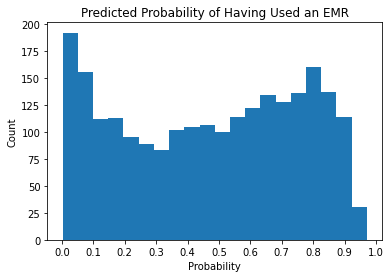

In [122]:
# plot the probability of having used an EMR
plt.hist(x=accessonlinerec_probs, bins=20)
plt.xticks(np.arange(0.0, 1.1, step = 0.1))
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Predicted Probability of Having Used an EMR');

This distribution has a large peak at the low end (\< 0.10) and a smaller one around 0.85. It is relatively flat in the middle, and as with the previous variable, there are few entries \> 0.90.

In [123]:
print('N >= 90% probability:', accessonlinerec_probs[accessonlinerec_probs >= 0.90].shape[0])
print('N <= 10% probability:', accessonlinerec_probs[accessonlinerec_probs <= 0.10].shape[0])

N >= 90% probability: 67
N <= 10% probability: 348


As the graph shows, this is very skewed toward lower probabilities. Let's try a wider range.

In [124]:
print('N >= 80% probability:', accessonlinerec_probs[accessonlinerec_probs >= 0.80].shape[0])
print('N <= 20% probability:', accessonlinerec_probs[accessonlinerec_probs <= 0.20].shape[0])

N >= 80% probability: 367
N <= 20% probability: 580


This is still skewed toward the lower end, but less so. 

Again, we want to look at characteristics of respondents in the high and low probability groups. As we did previously, we'll look at the 10 variables with the largest difference between predicted probability >= 0.80 and <= 0.20.

In [125]:
# append probabilities to the final X matrix
X_test_acconlrec_finprobs =  pd.concat([X_test_acconlrec_rfe_final, pd.Series(accessonlinerec_probs)], axis = 1)

In [126]:
# check it
display(X_test_acconlrec_finprobs.head())
display(X_test_acconlrec_finprobs.shape)

,highspanli,useinternet,electronic_selfhealthinfo,intrsn_visitedsocnet,regularprovider,healthinsurance,medconditions_diabetes,everhadcancer,selfgender_2,whruseinet_pubvother_1,...,tablet_discussionshcp_1,qualitycare_1,qualitycare_2,qualitycare_3,qualitycare_4,qualitycare_5,raceethn5_3,avgdrinks_cat_4,havedevice_cat_5,0
0,0,1,1,1,0,1,0,0,1,0,...,0,0,0,1,0,0,1,1,1,0.366881
1,0,1,1,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.469071
2,0,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.056373
3,0,1,1,1,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0.613879
4,0,1,1,1,1,1,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0.876105


(2328, 46)

In [127]:
# rename the probability column
X_test_acconlrec_finprobs.rename(columns = {0:"pred_proba"}, inplace = True)
display(X_test_acconlrec_finprobs.columns)

Index(['highspanli', 'useinternet', 'electronic_selfhealthinfo',
       'intrsn_visitedsocnet', 'regularprovider', 'healthinsurance',
       'medconditions_diabetes', 'everhadcancer', 'selfgender_2',
       'whruseinet_pubvother_1', 'whruseinet_pubvother_2',
       'internet_broadbnd_1', 'survey_cycle_3', 'survey_cycle_4',
       'survey_cycle_5', 'ownabilitytakecarehealth_5', 'educa_2', 'educa_3',
       'educa_4', 'tablethealthwellnessapps_1', 'hhinc_1', 'hhinc_2',
       'nchsurcode2013_4', 'nchsurcode2013_5', 'phq4_cat_4', 'maritalstatus_5',
       'censdiv_2', 'censdiv_6', 'censdiv_8', 'censdiv_9', 'smokestat_2',
       'smokestat_3', 'freqgoprovider_3', 'freqgoprovider_4',
       'freqgoprovider_5', 'freqgoprovider_6', 'tablet_discussionshcp_1',
       'qualitycare_1', 'qualitycare_2', 'qualitycare_3', 'qualitycare_4',
       'qualitycare_5', 'raceethn5_3', 'avgdrinks_cat_4', 'havedevice_cat_5',
       'pred_proba'],
      dtype='object')

In [128]:
# Get the top 10 categories by %age for predict probability >= 80 and <= 20
# denominators for %age
N_aor_80 = accessonlinerec_probs[accessonlinerec_probs >= 0.80].shape[0]
N_aor_20 = accessonlinerec_probs[accessonlinerec_probs <= 0.20].shape[0]

In [129]:
# list of columns
aor_cols = list(X_test_acconlrec_finprobs.columns)
aor_cols.remove('pred_proba')

In [130]:
# make a df for the results
df_aor_pcts = pd.DataFrame(index = aor_cols, columns = ['pct_ge80', 'pct_le20'])

In [131]:
# get the %age of each variable in the prob >= 80 and prob <= 20 groups
for col in aor_cols:
    df_aor_pcts.loc[col, 'pct_ge80'] = X_test_acconlrec_finprobs[col][X_test_acconlrec_finprobs['pred_proba'] >= 0.80].sum()/(0.01*N_aor_80)    
    df_aor_pcts.loc[col, 'pct_le20'] = X_test_acconlrec_finprobs[col][X_test_acconlrec_finprobs['pred_proba'] <= 0.20].sum()/(0.01*N_aor_20)

In [132]:
# get the difference
df_aor_pcts['diff'] = df_aor_pcts['pct_ge80'] - df_aor_pcts['pct_le20']
# and absolute difference for sorting
df_aor_pcts['absdiff'] = np.abs(df_aor_pcts['diff'])

In [133]:
df_topabs2 = df_aor_pcts.sort_values(by='absdiff', ascending=False).head(10)

In [134]:
df_topabs2

,pct_ge80,pct_le20,diff,absdiff
tablet_discussionshcp_1,91.008174,4.482759,86.525416,86.525416
tablethealthwellnessapps_1,91.825613,12.241379,79.584234,79.584234
electronic_selfhealthinfo,99.182561,30.172414,69.010148,69.010148
havedevice_cat_5,84.196185,19.827586,64.368599,64.368599
educa_4,77.384196,17.241379,60.142817,60.142817
useinternet,100.0,44.827586,55.172414,55.172414
intrsn_visitedsocnet,91.008174,39.137931,51.870243,51.870243
internet_broadbnd_1,64.032698,14.482759,49.549939,49.549939
regularprovider,95.640327,49.655172,45.985155,45.985155
whruseinet_pubvother_2,81.19891,37.241379,43.957531,43.957531


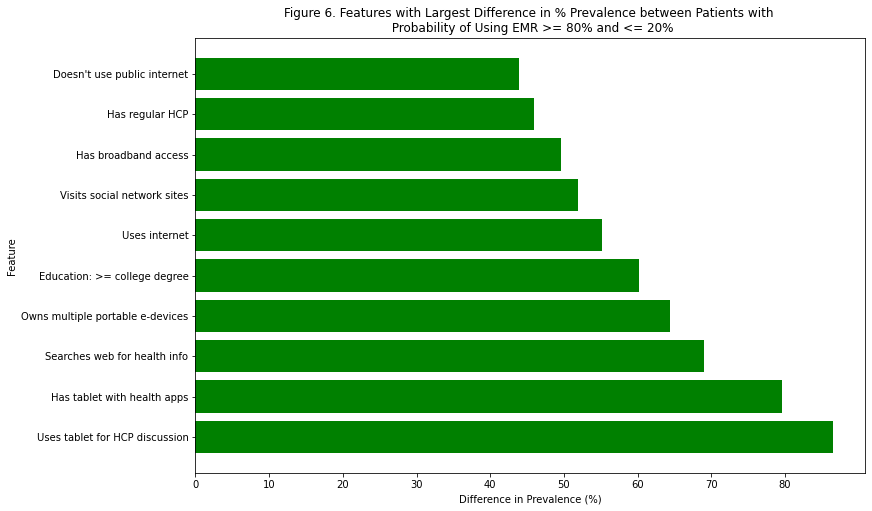

In [135]:
fig, bar4 = plt.subplots(figsize = (12,8))
y_labs2 = ['Uses tablet for HCP discussion', 'Has tablet with health apps', 'Searches web for health info',\
          'Owns multiple portable e-devices', 'Education: >= college degree', 'Uses internet', \
          'Visits social network sites', 'Has broadband access', 'Has regular HCP', "Doesn't use public internet"] 
df_topabs2['negpos'] = df_topabs2['diff'] < 0
bar4 = plt.barh(data=df_topabs2, y=np.arange(10), width='diff', tick_label=y_labs2,\
               color=df_topabs2['negpos'].map({True:'r', False:'g'}))
plt.title('Figure 6. Features with Largest Difference in % Prevalence between Patients with \n Probability of Using EMR >= 80% and <= 20%')
plt.xlabel('Difference in Prevalence (%)')
plt.ylabel('Feature')
plt.xticks(np.arange(0, 90, 10));

The 10 features with the biggest difference in prevalence between predicted probabilities of \>= 0.80 and \<= 0.20 of being having used an EMR in the past 12 months are shown above.  
Red bars would indicate features more prevalent in patients with predicted probability \<= 0.20 of having used an EMR. None of the features fall into this category.  
Green bars indicate features more prevalent in patients with predicted probability \>= 0.80 of having used an EMR. Unlike those offered access, there is no gender difference. Similarly, these patients are more likely to have at least a college degree. Medically, they are again more likely to have a regular HCP. Again similar to those offered access, the rest of the variables relate to internet access and use: they are more likely to use the internet and to have broadband internet access. They are less likely to access the internet via public resources (e.g. a library). They are more likely to use the internet to access social networking sites. They tend to have multiple portable electronic devices, to look for health information on the web, monitor their health with table apps, and use a tablet in discussions with their HCP.

In [31]:
# scoring metrics for the ML models
def get_scores(y_test, y_pred):
    '''
    get scores for the fitted models
    inputs:
    y_test (series) = true labels
    y_preds (series) = model predictions
    
    returns: 
    prec (float) : precision score
    rec (float): recall score
    acc (flot) : accuracy score
    '''
    
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average = 'weighted')
    rec = recall_score(y_test, y_pred, average = 'weighted')
    acc = accuracy_score(y_test, y_pred)
    print('confusion matrix:\n', cm)
    print('precision: {:.5f}; recall: {:.5f}, accuracy: {:.5f}'.format(prec, rec, acc))
    
    return prec, rec, acc

<a id="overallsum"></a>
## Overall Summary

In this analysis, three years of data from the National Cancer Institute's [HINTS](https://hints.cancer.gov/) were used to analyze patient attributes associated with access to and use of EMRs. Data were screened using the HINTS codebooks, cleaned, merged and split 70/30 into training and test datasets.  

Preliminary univariate analysis of the training set was carried out using Kruskal-Wallis and chi-squared contingency table methods, with significant variables retained for a multivariate machine learning model.  

After cleaning and univariate analysis, the initial set of 59 variables was reduced to 38 with a significant univariate relationship to EMR access and 41 with a significant univariate relationship to EMR use. After dealing with missing and erroneous data codes, the initial dataset of 11942 records was reduced to 7818 records: 5490 in the training set and 2328 in the test set. 

From these data, machine learning models were constructed using logistic regression. Expanding the categorical variables with dummy encodings resulted in 106 features for predicting access to an EMR and 109 for predicting use of an EMR. Feature reduction was accomplished with recursive feature elimination (RFE), initially with an automatic variable selection algorithm (RFECV), then using RFE with manually set feature thresholds to see further reduce the feature space. Overfitting was asssessed by looking for large discrepancies in precision, recall, and accuracy between the training and test set predictions. Adequacy of fit of the models was determined by precision and recall of predictions on the test set.

The original EMR access outcome variable (`offeredaccesseither`) was multi-class with three categories ("yes", "no", "don't know"). Fitting an RFECV automatically-pruned logistic regression model for this outcome resulted in 64 features, with relatively poor precision (0.622) and recall (0.555). Tuning the model parameters with a grid search resulted in a model with 81 features, and minimal improvements in precision (0.630) and recall (0.567).  

To potentially improve fit, the sparse "don't know" category was merged with "no", creating a binary outcome with better class balance. The binary model with default parameters and RFECV pruning had 52 features, and and improved precision (0.702) and recall (0.696). Grid-search tuning yielded a 93-feature model with essentially the same precision (0.706) and recall (0.700). Due to the increase in features and minimal improvement in fit, the latter model was discarded, and the former was taken as the starting point for manual feature reduction with RFE. From the initial 52-feature model, reduced models selected by RFE with between 5 and 50 parameters (in 5-parameter increments) were fit. Best precision (0.705) and recall (0.699) were obtained at 30 features, and this model was selected as the final one. 

Demographic features associated with increased predicted likelihood of EMR access were female gender, higher education, and moderately older age (65-74). There was also an effect of year (survey cycle), and the COVID-19 pandemic. Demographics associated with decreased likelihood of access were being single, low income, non-Hispanic Asian race, linguistic isolation, and residing in the East South Central census division.

Health-related features associated with increased predicted EMR access were having a regular HCP whose care was more highly rated, seeing that HCP two or more times yearly, having health insurance, and a history of cancer. Features in this category associated with less likelihood of access were public insurance (Medicare and/or Medicaid) alone, very heavy drinking, and low confidence in one's ability to manage health affairs.

E-device and internet-related factors predicting increased likelihood of access were internet use, increased use of e-devices and the web for health-related purposes, visiting social-networking sites, and degree of use of public internet access. No variable in this category predicted reduced access.

The strength of each feature was examined via its odds ratio. The features most strongly associated with increased access were having health insurance and highly rating one's care. Those most strongly associated with decreased likelihood of access were low confidence in one's ability to manage health affairs, and non-Hispanic Asian race. 

Finally, features with the largest difference in prevalence between those with predicted likelihood of \>= 80% and \<= 20% of being offered EMR access were assessed. Of the top ten, lower income was more prevalent in the low-likelihood group, while female gender, higher education level, having a regular HCP, higher HCP rating, and several variables relating to increased internet/device use and use for health-related purposes were more prevalent in the high-likelihood group.

Similar to the access variable, the EMR use variable (`accessonlinerecord`) was multiclass, except with five categories, relating to increased use frequency. The initial RFECV + logistic regression model for this outcome had 82 features and fair precision (0.607) with poor recall (0.471). Tuning the parameters with grid search gave a 99-parameter model with decreased precision (0.551) and slightly improved, but still poor, recall (0.517). 

As with the other outcome, the culprit was believed to be the less frequent categories causing imbalanced predictions. A binary outcome variable comparing "none" to "any" use of the EMR was therefore created. The default RFECV + logistic regression model for this outcome showed greatly improved precision (0.741) and recall (0.724) using 62 features. Grid-search tuning decreased the feature space to 54 but with lower precision (0.709) and recall (0.689).  Based on this, the 62-feature model was used as the starting point for manual RFE tuning. Models containing from 5 to 60 features (again in 5-feature increments) were created and their scores compared. Optimal precision (0.742) and recall (0.724) were obtained with both 45 and 50 features; 45 was selected as more parsimonious. 

Demographic features associated with increased predicted likelihood of EMR use were female gender, any education \>= high school,  and living in the Pacific (CA, OR, WA, AK, HI) census division. There was again an effect of year (survey cycle), and the COVID-19 pandemic. Demographics associated with decreased likelihood of use were being separated, lower income, Hispanic race, linguistic isolation, residing in the Middle Atlantic, East South Central, or Mountain census divisions, and residing in a more rural area.

Health-related features associated with increased predicted EMR use were having a regular HCP, see an HCP >= 3 times yearly, any care rating (aside from none/don't visit HCP), having health insurance, a history of diabetes or cancer, and being a current non-smoker. Features in this category associated with less likelihood of use were heavy drinking, severe psychological distress (highest PHQ-4 score) and low confidence in one's ability to manage health affairs.

E-device and internet-related factors predicting increased likelihood of EMR use were internet use, broadband access, having multiple e-devices, increased use of the devices and the web for health-related purposes, and degree of use of public internet access. As previously, no variable in this category predicted reduced use.

Examining odds ratios, an "excellent" HCP-care rating and >= college degree were most strongly associated with increased likelihood of EMR use.  Those most strongly associated with decreased likelihood of access were residing in the East South Central census division and in a linguistically-isolated area.  

Finally, prevalence differences between those with predicted likelihood of \>= 80% and \<= 20% of having used an EMR were assessed. The top ten were all more common in those predicted more likely to use an EMR. With the exception of education >= college degree and having a regular HCP, all were related to increased internet and e-device access/use for both general and health-related purposes. 

<a id="conclusions"></a>
## Conclusions

The machine learning models were able to identify features associated with EMR access and use using data from publicly-available US government datasets.

Survey respondents more likely to be offered access to an EMR by their HCP or insurer tended to be better-educated, female, and to more heavily use electronic resources for health information. These characteristics could indicate some bias toward offering EMR access to those most likely to use them. This possibility should be studied further to enhance equality of access to EMRs.

They also tended to visit their HCPs more frequently, possibly indicating more complex medical needs. In terms of chronic conditions, only having had cancer predicted higher likelihood of being offered access. Whether there is a need to more aggressively offer access to patients with other chronic conditions should be further explored.

Finally, there was a time effect, with access increasing with survey cycle. However, the post-pandemic 2020 variable had less influence than the pre-pandemic 2020 variable, so there was not an obvious bump in EMR availability in the (admittedly limited) post-pandemic period for which data are available.

Conversely, those less likely to be offered EMR access were in the lowest education and annual income tiers, were more likely to live in the East South Central census division and linguistically isolated areas, tended to be single, more likely on public health insurance, and to be heavy drinkers and to have very low confidence in their ability to manage their healthcare. Most of these variables indicate patients less likely generally to have access to resources, including healthcare. These patients may have less interaction with their HCPs, or may be pre-judged poor candidates by their HCPs. Linguistic isolation indicates they may be poor English speakers and not be able to communicate well with HCPs. They could potentially benefit from educational initiatives, preferably in their native language, promoting the value of EMRs and offering instruction on their use. HCPs could also potentially be unaware of unconscious biases regarding these patients, and could also possibly benefit from incentives to expand EMR access to underserved patients. 

Similarly, those more likely to use an EMR also tended to be female, more educated, more frequent visitors to their HCPs, and to be more frequent users of electronic devices and health-related information. In terms of chronic conditions, both diabetes and cancer histories predicted increased EMR use. 

The time effect was the same as for EMR access, with use increasing with each survey cycle, but with the post-pandemic period less influential than pre-pandemic 2020. 

Again, it appears more electronically- and health-literate patients tend to be more likely to use EMRs. Appropriately, those with higher HCP visit frequencies and chronic conditions are more likely to use EMRs. These patients may have complex medical histories and multiple HCPs, and should benefit from having their information be more portable in electronic form, as well as from having access to their data for discussions with HCPs or family members. 

Also similar to those less likely to be offered EMR access, those predicted less likely to use an EMR tend to be in the lowest income category, to reside in the East South Central census division and in linguistically isolated areas, rate their ability to manage their own care poorly, and tend to be heavier drinkers. These similarities may be due to the fact that those not offered EMR access will also not have used an EMR. 

Additionally, these patients tend to come from more rural areas, to be in the second-lowest income bracket, to identify as Hispanic, to meet PHQ-4 criteria for severe psychological distress. These indicators again identify a group of patients who may have less access to resources, particularly healthcare. Severe psychological distress may indicate those who need more support/assistance to manage their health affairs. As above, these patients may benefit from language-appropriate, targeted outreach and education to emphasize the availability and benefits of an EMR. 

<a id="limitations"></a>
### Limitations

The dataset was limited to fields available from HINTS, which is not specifically designed as a survey of EMR use.
While the HINTS survey is designed to be representative of the US population, the fields of interest for this study had a fair number of missing entries, whose deletion may have altered the composition of the sample to be less representative.  
While data were available on patients' history of several chronic conditions, no data were available on the complexity of patients' overall medical condition or their comorbidity burden. These factors may increase the need for multiple HCP visits as well as visits to multiple different HCPs, which would increase the need for access to a usable, portable HCP.  
Similarly, the survey does not elucidate how many different HCPs a patient sees. It also does not have data on urgent-care, emergency, or inpatient medical visits. The need for multiple of these may indicate patients who need closer follow-up, who may access multiple sources of healthcare, and who might benefit from having access to their multiple-source healthcare records.  
Finally, since the survey is conducted between January and April of each year, the post-pandemic data for 2020 only cover a limited time period. 

<a id="improve"></a>
### Areas for Improvement and Future Study

Further studies could assess in depth the barriers HCPs face to educating patients on and disseminating access to EMRs. Is there a lack of resources in HCPs' offices to discuss and educate patients on EMRs, potentially creating a bias toward offering them primarily to "likely adopters" who need less assistance? Similarly, could there be a lack of |interest in managing the patient-facing aspects of the EMR and its possibly increased burden on HCP staff?

Another area for additional study could include examining the reasons patients with EMR access do not use them. Questions related to this are part of HINTS, but that additional analysis was beyond the scope of this project. Perhaps some patients prefer direct in-person interaction when discussion complex health matters, or perhaps they feel the data in the EMR are not useful outside the context of the actual visit. Their could also be privacy concerns about accessing such sensitive data electronically.
  
Additionally, assessing patient and HCP perceptions of the pros and cons of the various EMRs, especially in terms of their usability. From the patient end, it would be useful to know whether the data available come with any patinet-friendly interpretation as (e.g.) raw diagnostic tests or lab results would be mostly uninterpretable by those with no medical background.  

Although interoperability is a very specific goal of the Center for Medicare and Medicaid Services' EMR ["Meaningful Use" initiative](https://www.cms.gov/Regulations-and-Guidance/Legislation/EHRIncentivePrograms/Downloads/Stages_ofMeaningfulUseTablepdf.pdf), it would also be worthwhile to study how interoperable the various EMR systems actually are, especially from the perspective of the end-user. This would be especially relevant to patients with multiple providers who might use different EMR platforms. 

Finally, there was not a clear increase in access to or use of EMRs in the post-pandemic period. There was a time effect, with access increasing with survey cycle, but not a larger increase for the post-pandemic cycle. However, the post-pandemic period studied was relatively short and further follow-up may better elucidate whether or not this unique circumstance affected EMR access and use.